In [ ]:
%run PNe_fitting

In [ ]:
%whos
%who_ls


In [1]:
gal_name = "FCC255"

In [566]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Ellipse, Circle
from astropy.io import ascii, fits
from astropy.wcs import WCS, utils, wcs
from astropy.table import Table
from astropy.coordinates import SkyCoord, Angle
from astropy import units as u
from lmfit import minimize, Minimizer, report_fit, Model, Parameters
import lmfit
import pandas as pd
from photutils import CircularAperture
from IPython.display import display
from MUSE_Models import PNe_residuals_3D, PNe_spectrum_extractor, PNextractor, PSF_residuals_3D, data_cube_y_x, robust_sigma
from PNLF import open_data, reconstructed_image, completeness
import yaml
import sep
from photutils import CircularAperture
import scipy as sp
from scipy.stats import norm
from scipy import stats
from ppxf_gal_L import ppxf_L_tot
from astroquery.vizier import Vizier

%config InlineBackend.figure_format = 'retina'

In [4]:
# functions
# Open Fits file and assign to raw_data

hdulist = fits.open(gal_name+"_data/"+gal_name+"_residuals_list.fits")
hdr = hdulist[0].header
wavelength = np.exp(hdulist[1].data)

if gal_name == "FCC219" or gal_name =="FCC193" or gal_name =="FCC083":
    x_data, y_data, n_data = data_cube_y_x(len(hdulist[0].data))
elif gal_name == "FCC161":
    y_data, x_data = 451, 736
else:
    y_data, x_data, n_data = data_cube_y_x(len(hdulist[0].data))
    
    
n_pixels = 9    # minicube FOV in pixels
c = 299792458.0 # speed of light

coordinates = [(n,m) for n in range(n_pixels) for m in range(n_pixels)]
x_fit = np.array([item[0] for item in coordinates])
y_fit = np.array([item[1] for item in coordinates])


def progbar(curr, total, full_progbar):
    frac = curr/total
    filled_progbar = round(frac*full_progbar)
    print('\r', '#'*filled_progbar + '-'*(full_progbar-filled_progbar), '[{:>7.2%}]'.format(frac), str(curr)+"/"+ str(total), end='')

# Load in data and plot FOV

In [5]:
# Pull out the 1D flux data from 1D fits to do radial comparison

gauss_1D_A = np.load("exported_data/"+gal_name+"/gauss_A_cen.npy")
A_rN_plot = np.load("exported_data/"+gal_name+"/A_rN_cen.npy")

gauss_A_shape = gauss_1D_A.reshape(y_data, x_data)
rN = np.load("exported_data/"+gal_name+"/rN.npy")
rN_shape = rN.reshape(y_data,x_data)
#rN_shape[np.isnan(rN_shape)] = 0

Flux_1D = gauss_1D_A * np.sqrt(2*np.pi) * 1.19
Flux_1D_cube = Flux_1D.reshape(y_data, x_data)
A_rN_plot_shape = A_rN_plot.reshape(y_data, x_data)

#PNe_1D_flux_data = np.array([PNextractor(x, y, n_pixels, Flux_1D_cube, dim=1.0) for x,y in zip(x_PNe,y_PNe)])
#PNe_1D_A_rN_data = np.array([PNextractor(x, y, n_pixels, A_rN_plot_shape, dim=1.0) for x,y in zip(x_PNe,y_PNe)])

In [6]:
x_y_list = np.load("exported_data/"+gal_name+"/PNe_x_y_list.npy")
x_PNe = np.array([x[0] for x in x_y_list])
y_PNe = np.array([y[1] for y in x_y_list])

PNe_spectra = np.array([PNe_spectrum_extractor(x, y, n_pixels, hdulist[0].data, x_data, wave=wavelength) for x,y in zip(x_PNe, y_PNe)])

PNe_df = pd.DataFrame(columns=("PNe number", "Ra (J2000)", "Dec (J2000)", "V (km/s)", "m 5007", "M 5007", "[OIII] Flux", "M 5007 error","A/rN", "rad D", "redchi", "Filter"))
PNe_df["PNe number"] = np.arange(0,len(x_PNe)) # PNe numbers
PNe_df["Filter"] = "Y"

# Objective Residual Cube
obj_residual_cube = fits.open("exported_data/"+gal_name+"/resids_obj.fits")

# Data Residual Cube
data_residual_cube = fits.open("exported_data/"+gal_name+"/resids_data.fits")


def uncertainty_cube_construct(data, x_P, y_P, n_pix):
    data[data == np.inf] = 0.01
    extract_data = np.array([PNe_spectrum_extractor(x, y, n_pix, data, x_data, wave=wavelength) for x,y in zip(x_P, y_P)])
    array_to_fill = np.zeros((len(x_P), n_pix*n_pix, len(wavelength)))
    for p in np.arange(0, len(x_P)):
        list_of_std = np.abs([robust_sigma(dat) for dat in extract_data[p]])
        array_to_fill[p] = [np.repeat(list_of_std[i], len(wavelength)) for i in np.arange(0, len(list_of_std))]
  
    return array_to_fill

error_cube = uncertainty_cube_construct(data_residual_cube[0].data, x_PNe, y_PNe, n_pixels)
obj_error_cube = uncertainty_cube_construct(obj_residual_cube[0].data, x_PNe, y_PNe, n_pixels)

In [4]:
with open("galaxy_info.yaml", "r") as yaml_data:
    galaxy_info = yaml.load(yaml_data, Loader=yaml.FullLoader)
    
galaxy_data = galaxy_info[gal_name]

emission_dict = galaxy_data["emissions"]

#D = galaxy_data["Distance"]

z = galaxy_data["z"]

gal_mask = galaxy_data["gal_mask"]
gal_vel = galaxy_data["velocity"]
star_mask = galaxy_data["star_mask"]

In [8]:
PNe_multi_params = Parameters()

def gen_params(wave=5007, FWHM=4.0, FWHM_err=0.1, beta=2.5, beta_err=0.3, LSF=2.81, em_dict=None, vary_LSF=False, vary_PSF=False):
    # loop through emission dictionary to add different element parameters 
    for em in em_dict:
        #Amplitude params for each emission
        PNe_multi_params.add('Amp_2D_{}'.format(em), value=emission_dict[em][0], min=0.001, max=1e5, expr=emission_dict[em][1])
        #Wavelength params for each emission
        if emission_dict[em][2] == None:
            PNe_multi_params.add("wave_{}".format(em), value=wave, min=wave-40., max=wave+40.)
        else:
            PNe_multi_params.add("wave_{}".format(em), expr=emission_dict[em][2].format(z))
    
    PNe_multi_params.add("x_0", value=((n_pixels//2.) +1), min=((n_pixels//2.) +1)-3, max=((n_pixels//2.) +1)+3)
    PNe_multi_params.add("y_0", value=((n_pixels//2.) +1), min=((n_pixels//2.) +1)-3, max=((n_pixels//2.) +1)+3)
    PNe_multi_params.add("LSF", value=LSF, vary=vary_LSF, min=LSF-1, max=LSF+1)
    PNe_multi_params.add("M_FWHM", value=FWHM, min=FWHM - FWHM_err, max=FWHM + FWHM_err, vary=vary_PSF)
    PNe_multi_params.add("beta", value=beta, min=beta - beta_err, max=beta + beta_err, vary=vary_PSF)   
    PNe_multi_params.add("Gauss_bkg",  value=0.0001, vary=True)#1, min=-200, max=500)
    PNe_multi_params.add("Gauss_grad", value=0.0001, vary=True)#1, min=-2, max=2)
    
# storage setup
total_Flux = np.zeros((len(x_PNe),len(emission_dict)))
A_2D_list = np.zeros((len(x_PNe),len(emission_dict)))
F_xy_list = np.zeros((len(x_PNe), len(emission_dict), len(PNe_spectra[0])))
moff_A = np.zeros((len(x_PNe),len(emission_dict)))
model_spectra_list = np.zeros((len(x_PNe), n_pixels*n_pixels, len(wavelength)))
mean_wave_list = np.zeros((len(x_PNe),len(emission_dict)))
residuals_list = np.zeros(len(x_PNe))
list_of_fit_residuals = np.zeros((len(x_PNe), n_pixels*n_pixels, len(wavelength)))
chi_2_r = np.zeros((len(x_PNe)))

# error lists
moff_A_err = np.zeros((len(x_PNe), len(emission_dict)))
x_0_err = np.zeros((len(x_PNe), len(emission_dict)))
y_0_err = np.zeros((len(x_PNe), len(emission_dict)))
mean_wave_err = np.zeros((len(x_PNe), len(emission_dict)))
Gauss_bkg_err = np.zeros((len(x_PNe), len(emission_dict)))
Gauss_grad_err = np.zeros((len(x_PNe), len(emission_dict)))

list_of_x = np.zeros(len(x_PNe))
list_of_y = np.zeros(len(x_PNe))
Gauss_bkg = np.zeros(len(x_PNe))
Gauss_grad = np.zeros(len(x_PNe))

def run_minimiser(parameters):
    for PNe_num in np.arange(0, len(x_PNe)):
        progbar(int(PNe_num)+1, len(x_PNe), 40)
        useful_stuff = []        
        PNe_minimizer     = lmfit.Minimizer(PNe_residuals_3D, PNe_multi_params, fcn_args=(wavelength, x_fit, y_fit, PNe_spectra[PNe_num], error_cube[PNe_num], PNe_num, emission_dict, useful_stuff), nan_policy="propagate")
        multi_fit_results = PNe_minimizer.minimize()
        total_Flux[PNe_num] = np.sum(useful_stuff[1][1],1) * 1e-20
        list_of_fit_residuals[PNe_num] = useful_stuff[0]
        A_2D_list[PNe_num]  = useful_stuff[1][0]
        F_xy_list[PNe_num]  = useful_stuff[1][1]
        model_spectra_list[PNe_num] = useful_stuff[1][3]
        moff_A[PNe_num]  = [multi_fit_results.params["Amp_2D_{}".format(em)] for em in emission_dict]
        mean_wave_list[PNe_num]     = [multi_fit_results.params["wave_{}".format(em)] for em in emission_dict]   
        chi_2_r[PNe_num]    = multi_fit_results.redchi
        list_of_x[PNe_num]  = multi_fit_results.params["x_0"]
        list_of_y[PNe_num]  = multi_fit_results.params["y_0"]
        Gauss_bkg[PNe_num]  = multi_fit_results.params["Gauss_bkg"]
        Gauss_grad[PNe_num] = multi_fit_results.params["Gauss_grad"]
        #save errors
        moff_A_err[PNe_num]     = [multi_fit_results.params["Amp_2D_{}".format(em)].stderr for em in emission_dict]
        mean_wave_err[PNe_num]  = [multi_fit_results.params["wave_{}".format(em)].stderr for em in emission_dict]
        x_0_err[PNe_num]        = multi_fit_results.params["x_0"].stderr
        y_0_err[PNe_num]        = multi_fit_results.params["y_0"].stderr
        Gauss_bkg_err[PNe_num]  = multi_fit_results.params["Gauss_bkg"].stderr
        Gauss_grad_err[PNe_num] = multi_fit_results.params["Gauss_grad"].stderr

    # Signal to noise and Magnitude calculations
    list_of_rN = np.array([robust_sigma(PNe_res) for PNe_res in list_of_fit_residuals])
    PNe_df["A/rN"] = A_2D_list[:,0] / list_of_rN # Using OIII amplitude
    
    # chi square analysis
    gauss_list, redchi, Chi_sqr = [], [], []
    for p in range(len(x_PNe)):
        PNe_n = np.copy(PNe_spectra[p])
        flux_1D = np.copy(F_xy_list[p][0])
        A_n = ((flux_1D) / (np.sqrt(2*np.pi) * 1.19))
    
        def gaussian(x, amplitude, mean, stddev, bkg, grad):
            return ((bkg + grad*x) + np.abs(amplitude) * np.exp(- 0.5 * (x - mean)** 2 / (stddev**2.)) +
                    (np.abs(amplitude)/2.85) * np.exp(- 0.5 * (x - (mean - 47.9399))** 2 / (stddev**2.)))
    
        list_of_gauss = [gaussian(wavelength, A, mean_wave_list[p][0], 1.19, Gauss_bkg[p], Gauss_grad[p]) for A in A_n]
        for kk in range(len(PNe_n)):
            temp = np.copy(list_of_gauss[kk])
            idx  = np.where(PNe_n[kk] == 0.0)[0]
            temp[idx] = 0.0
            PNe_n[kk,idx] = 1.0
            list_of_gauss[kk] = np.copy(temp)
        rN   = robust_sigma(PNe_n - list_of_gauss)
        res  = PNe_n - list_of_gauss
        Chi2 = np.sum((res**2)/(rN**2))
        s    = np.shape(PNe_n)
        redchi.append(Chi2/(len(wavelength)*n_pixels**2 - PNe_minimizer.nfree))
        gauss_list.append(list_of_gauss)
        Chi_sqr.append(Chi2)
    
    PNe_df['Chi2']   = Chi_sqr
    PNe_df["redchi"] = redchi
    
    # velocity
    de_z_means = np.array(mean_wave_list[:,0] / (1 + z)) # de redshift OIII wavelength position
    
    PNe_df["V (km/s)"] = (c * (de_z_means - 5006.77) / 5006.77) / 1000.    
        
    PNe_df["[OIII] Flux"] = total_Flux[:,0] #store total OIII 5007 line flux
        
    if "hb" in emission_dict:
        PNe_df["[OIII]/Hb"] = PNe_df["[OIII] Flux"] / total_Flux[:,2] # store [OIII]/Hb ratio

    if "ha" in emission_dict:
        PNe_df["Ha Flux"] = total_Flux[:, 1]
    
    PNe_df["m 5007"] = -2.5 * np.log10(PNe_df["[OIII] Flux"].values) - 13.74


In [9]:
print("Running fitter")
if gal_name == "FCC219":
    gen_params(wave=5007*(1+z)-3, FWHM=galaxy_data["FWHM"], beta=galaxy_data["beta"], LSF=galaxy_data["LSF"], em_dict=emission_dict)
else:
    gen_params(wave=5007*(1+z), FWHM=galaxy_data["FWHM"], beta=galaxy_data["beta"], LSF=galaxy_data["LSF"], em_dict=emission_dict)
    
run_minimiser(PNe_multi_params)

Running fitter
 ######################################## [100.00%] 43/43

In [ ]:
marc_data = ascii.read("FCC167_data/Marc_measured_PNe_OIII_flux.txt")
marc_flux = 40*marc_data["col2"]*1e-20
marc_mag = -2.5 * np.log10(marc_flux) - 13.74

plt.hist(marc_mag[y_idx], color="g")
plt.hist(PNe_df["m 5007"].loc[PNe_df["Filter"]=="Y"])


In [ ]:
moff_params_for_gandalf = np.array([moff_A[:,0], galaxy_data["FWHM"], galaxy_data["beta"], list_of_x, list_of_y])
np.save("exported_data/"+gal_name+"/fitted_moffat_params", moff_params_for_gandalf)

In [ ]:
def Moffat(Moff_A, FWHM, beta, x_0, y_0):
    gamma = FWHM / (2. * np.sqrt(2.**(1./beta) - 1.))
    rr_gg = ((np.array(x_fit) - x_0)**2 + (np.array(y_fit) - y_0)**2) / gamma**2
    Moff = Moff_A * (1 + rr_gg)**(-beta)
    
    return Moff/np.sum(Moff)

list_of_params = np.load("exported_data/"+gal_name+"/fitted_moffat_params.npy")
list_of_Moff = [Moffat(list_of_params[0][n],list_of_params[1],list_of_params[2],list_of_params[3][n],list_of_params[4][n]) for n in range(len(x_PNe))]




## The Great Filter

In [10]:
PNe_df["Filter"] = "Y"
PNe_df.loc[PNe_df["A/rN"]<3., "Filter"] = "N"
# reduced Chi sqr cut
redchi_med = np.median(PNe_df["redchi"].values)
redchi_std = robust_sigma(PNe_df["redchi"].values)
lower_redchi = redchi_med - 3*redchi_std
upper_redchi = redchi_med + 3*redchi_std
PNe_df.loc[(PNe_df["redchi"]>=upper_redchi) & (PNe_df["redchi"]<=lower_redchi), "Filter"] = "N"


## FCC167
if gal_name == "FCC167":
    PNe_df.loc[PNe_df["PNe number"]==30, "Filter"] = "N" # Over luminous [OIII] source
    PNe_df.loc[PNe_df["PNe number"]==15, "Filter"] = "N" # SNR maybe, extended source with dual peaked [OIII] 5007
    #PNe_df.loc[PNe_df["PNe number"]==126, "Filter"] = "N" # SNR maybe, extended source
## FCC219
#elif gal_name == "FCC219":
    # Put filtered out objects here
elif gal_name == "FCC193":
    PNe_df.loc[PNe_df["PNe number"]==137, "Filter"] = "N" 
    PNe_df.loc[PNe_df["PNe number"]==59, "Filter"] = "N"
    PNe_df.loc[PNe_df["PNe number"]==136, "Filter"] = "N"
    PNe_df.loc[PNe_df["PNe number"]==122, "Filter"] = "N"
#elif gal_name == "FCC147":
    #PNe_df.loc[PNe_df["PNe number"]==41, "Filter"] = "N"
    

print(len(PNe_df["Filter"].loc[PNe_df["Filter"]=="Y"]))
plt.hist(PNe_df["m 5007"].loc[PNe_df["Filter"]=="Y"], bins=12);
plt.show()

38


# Error analysis

In [11]:
def Moffat_err(Moff_A, FWHM, beta, x_0, y_0):
        gamma = FWHM / (2. * np.sqrt(2.**(1./beta) - 1.))
        rr_gg = ((np.array(x_fit) - x_0)**2 + (np.array(y_fit) - y_0)**2) / gamma**2
        F_OIII_xy_dist = Moff_A * (1 + rr_gg)**(-beta)
    
        return np.sum(F_OIII_xy_dist*1e-20)
    
def error_sim(n_sim, n_PNe):
    mean_flux = np.ones(n_PNe)
    flux_err  = np.ones(n_PNe)
    mean_m5007 = np.ones(n_PNe)
    m5007_err = np.ones(n_PNe)
    for n in np.arange(0,n_PNe):
        Moff_A_dist = np.random.normal(moff_A[n][0], moff_A_err[n][0],n_sim)
        FWHM_dist = np.random.normal(galaxy_data["FWHM"], galaxy_data["FWHM_err"], n_sim)
        beta_dist = np.random.normal(galaxy_data["beta"], galaxy_data["beta_err"], n_sim)
        x_0_dist = np.random.normal(list_of_x[n], x_0_err[n][0], n_sim)
        y_0_dist = np.random.normal(list_of_y[n], y_0_err[n][0], n_sim)
        
        flux_array = [Moffat_err(Moff_A_dist[i], FWHM_dist[i], beta_dist[i], x_0_dist[i], y_0_dist[i]) for i in range(0,n_sim)]

        mean_flux[n], flux_err[n] = norm.fit(flux_array)
        
        mean_m5007[n], m5007_err[n] = norm.fit(-2.5*np.log10(flux_array)-13.72)

    return mean_flux, flux_err, mean_m5007, m5007_err

mean_flux, PNe_df["Flux error"], mean_m5007, PNe_df["m 5007 error"] = error_sim(5000, len(x_PNe))

## Show F_err in percentage terms
PNe_df["F[OIII] err percent"] = (PNe_df["Flux error"] / PNe_df["[OIII] Flux"])*100

## Distance estimate with error

In [13]:
PNe_df.loc[PNe_df["Filter"]=="Y"].nsmallest(3, "m 5007")

PNe number Ra (J2000) Dec (J2000)   V (km/s)     m 5007 M 5007  \
2            2        NaN         NaN  25.551022  27.168412    NaN   
30          30        NaN         NaN -59.018328  27.301168    NaN   
6            6        NaN         NaN   7.895014  27.313586    NaN   

     [OIII] Flux M 5007 error       A/rN rad D    redchi Filter          Chi2  \
2   4.331471e-17          NaN  22.731922   NaN  1.011205      Y  15234.820794   
30  3.832947e-17          NaN   8.292154   NaN  0.995740      Y  15001.816138   
6   3.789358e-17          NaN  17.381974   NaN  1.011512      Y  15239.435301   

      Flux error  m 5007 error  F[OIII] err percent  
2   1.025337e-18      0.025656             2.367180  
30  1.333280e-18      0.037744             3.478473  
6   9.257960e-19      0.026472             2.443148

In [12]:
p_n = int(PNe_df.loc[PNe_df["Filter"]=="Y"].nsmallest(1, "m 5007").index.values)
flux = PNe_df["[OIII] Flux"].iloc[p_n]
flux_err = PNe_df["Flux error"].iloc[p_n]
m = PNe_df["m 5007"].iloc[p_n]
m_err = PNe_df["m 5007 error"].iloc[p_n]

Dist_est = 10.**(((m + 4.51) -25.) / 5.)
dist_diff_p = 10.**(((m+m_err + 4.51) -25.) / 5.)
dist_diff_m = 10.**(((m-m_err + 4.51) -25.) / 5.)
print("Distance Estimate from PNLF: ", "{:.3f}".format(Dist_est), "Mpc, +{0:.4f} -{1:.4f}".format(dist_diff_p-Dist_est, Dist_est-dist_diff_m),"Mpc")

dM =  5. * np.log10(Dist_est) + 25.
dM_lower = 5. * np.log10(dist_diff_p) + 25.
dM_upper = 5. * np.log10(dist_diff_m) + 25.

print("dM = {:.4f}".format(dM),"+/- {:.4f}".format(dM-dM_upper))

PNe_df["M 5007"] = PNe_df["m 5007"] - dM

Distance Estimate from PNLF:  21.661 Mpc, +0.2548 -0.2519 Mpc
dM = 31.6784 +/- 0.0254


### FCC167

### FCC219

### FCC193
Distance Estimate from PNLF:  19.152 Mpc, +0.2253 -0.2226 Mpc
dM = 31.4111 +/- 0.0254

### FCC161
Distance Estimate from PNLF:  17.550 Mpc, +0.4189 -0.4092 Mpc
dM = 31.2214 +/- 0.0512
or
Distance Estimate from PNLF:  19.783 Mpc, +0.2522 -0.2491 Mpc
dM = 31.4815 +/- 0.0275

### FCC147
Distance Estimate from PNLF:  20.891 Mpc, +0.4028 -0.3951 Mpc
dM = 31.5998 +/- 0.0415

Distance Estimate from PNLF:  19.026 Mpc, +0.3621 -0.3554 Mpc
dM = 31.3967 +/- 0.0409

### FCC083
Distance Estimate from PNLF:  17.875 Mpc, +0.2058 -0.2035 Mpc
dM = 31.2612 +/- 0.0249

### FCC255
Distance Estimate from PNLF:  20.609 Mpc, +0.2875 -0.2835 Mpc
dM = 31.5703 +/- 0.0301
  OR
Distance Estimate from PNLF:  21.661 Mpc, +0.2548 -0.2519 Mpc
dM = 31.6784 +/- 0.0254

## Pixel array size experiment

In [ ]:
# n_pix_dist = 31
n_range = np.arange(11,22,2)
store_here = np.ones(len(n_range))
for i, n_pix_dist in enumerate(n_range):
    coordinates = [(n,m) for n in range(n_pix_dist) for m in range(n_pix_dist)]
    x_fit = np.array([item[0] for item in coordinates])
    y_fit = np.array([item[1] for item in coordinates])
    
    n_sim = 10000
    Moff_A_dist = np.random.normal(moff_A[40][0], moff_A_err[40][0],n_sim)
    FWHM_dist = np.random.normal(4.06, 0.018, n_sim)
    beta_dist = np.random.normal(3.41, 0.167, n_sim)
    x_0_dist = np.random.normal(list_of_x[40], x_0_err[40][0], n_sim)
    y_0_dist = np.random.normal(list_of_y[40], y_0_err[40][0], n_sim)
    
    def Moffat_err(Moff_A, FWHM, beta, x_0, y_0):
        gamma = FWHM / (2. * np.sqrt(2.**(1./beta) - 1.))
        rr_gg = ((np.array(x_fit) - x_0)**2 + (np.array(y_fit) - y_0)**2) / gamma**2
        F_OIII_xy_dist = Moff_A * (1 + rr_gg)**(-beta)
    
    
        return np.sum(F_OIII_xy_dist*1e-20)
    
    flux_array = [Moffat_err(Moff_A_dist[i], FWHM_dist[i], beta_dist[i], x_0_dist[i], y_0_dist[i]) for i in range(0,n_sim)]
    plt.hist(flux_array)
    plt.axvline(PNe_df["[OIII] Flux"].iloc[40])
    #plt.xlim(3.6e-17, 4.2e-17)
    #print(PNe_df["[OIII] Flux"].iloc[40])
    #print(PNe_df["m 5007"].iloc[40])
    mu_f, std_f = norm.fit(flux_array)
    #print(mu, (std/mu)*100,"%")
    plt.axvline(mu_f, c="r")
    
    mu, std = norm.fit(-2.5*np.log10(flux_array)-13.72)
    #print(mu, std)
    store_here[i] = mu_f

print(np.abs((-2.5*np.log10(store_here.max()) - 13.74)  -  (-2.5*np.log10(store_here[1]) - 13.74)))

plt.figure()
plt.plot(n_range, store_here)
plt.axvline(n_pixels)
# Correction for n_pixel and flux variation from fit

## Integrated spectrum with fit

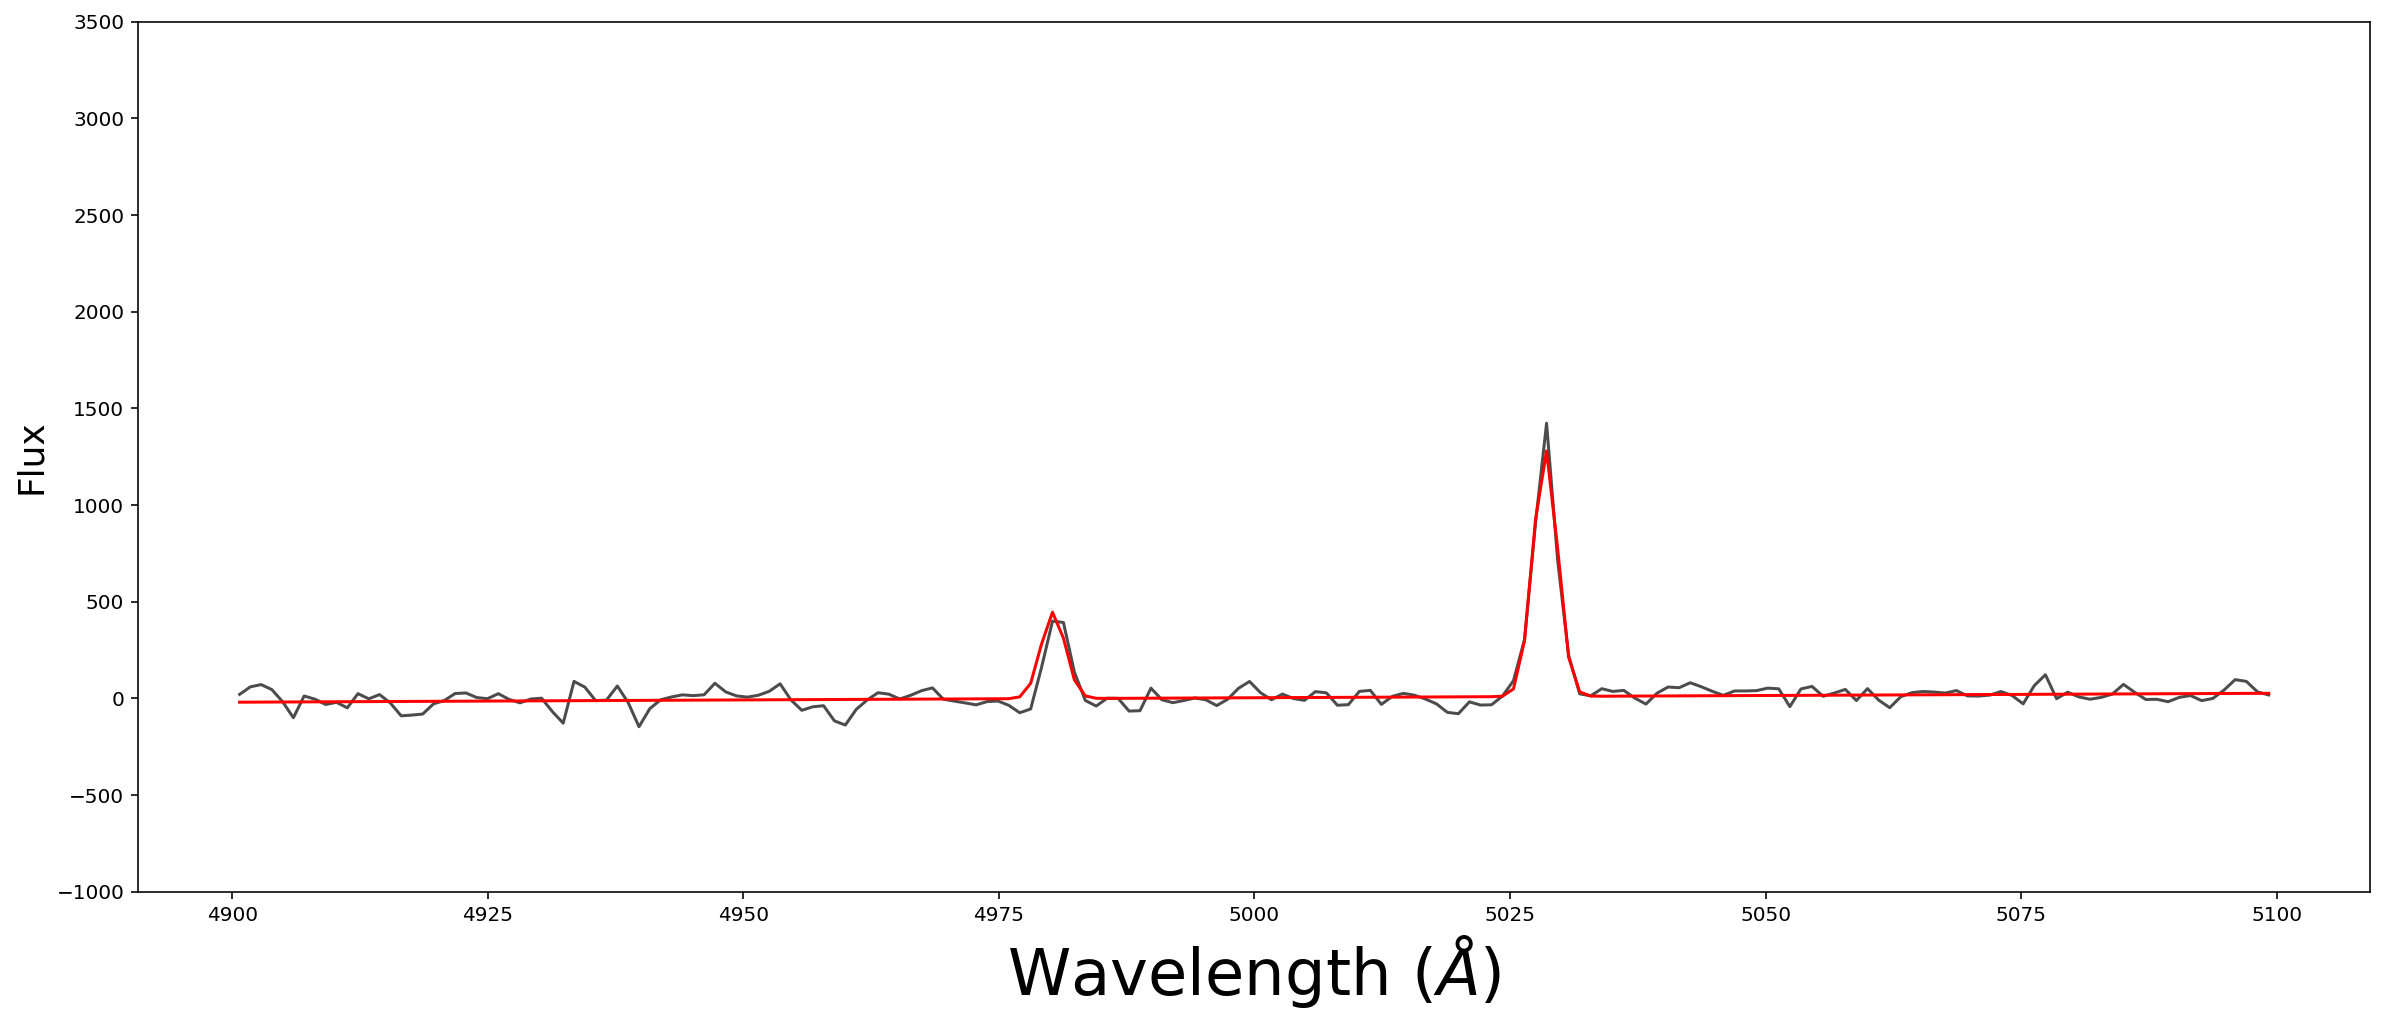

In [15]:
p = 6
plt.figure(figsize=(20,8))
plt.plot(wavelength, np.sum(PNe_spectra[p],0), alpha=0.7, c="k") # *moff_weight[:,None]

plt.plot(wavelength, np.sum(model_spectra_list[p],0), c="r")
plt.xlabel("Wavelength ($\AA$)", fontsize=32)
plt.ylabel("Flux", fontsize=18);
plt.ylim(-1000,3500);
#plt.axvline(5042)
#plt.xlim(4900,5100)
#plt.axvline(5039)
#plt.axvline(5033)

## Spaxel by spaxel with individual fits

In [ ]:
p = 27
PNe_n = PNe_spectra[p]
flux_1D = F_xy_list[p][0]
A_n = ((flux_1D) / (np.sqrt(2*np.pi) * 1.19))

def gaussian(x, amplitude, mean, stddev, bkg, grad):
    return (bkg + grad*x + np.abs(amplitude) * np.exp(- 0.5 * (x - mean)** 2 / (stddev**2.)) +
            (np.abs(amplitude)/2.85) * np.exp(- 0.5 * (x - (mean - 47.9399))** 2 / (stddev**2.)))

list_of_gauss = [gaussian(wavelength, A, mean_wave_list[p][0], 1.19, Gauss_bkg[p], Gauss_grad[p]) for A in A_n]

fig = plt.figure(figsize=(80,40))

ax = fig.add_subplot(1,1,1)
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)


for i, spec in enumerate(PNe_n):
    ax1 = fig.add_subplot(n_pixels,n_pixels,i+1)
    fig.subplots_adjust(wspace=0.25, hspace=0.3)
    ax1.plot(wavelength, spec, c="k")
    ax1.plot(wavelength, list_of_gauss[i], c="r", alpha=1.0)
    ax1.tick_params(labelsize = 14, pad=8)
    ax1.set_xlim(4900,5100)
    ax1.set_ylim(-25, 100)

    
ax.set_ylabel("Flux Density ($10^{-20}$ $erg s^{-1}$ $cm^{-2}$ $\AA^{-1}$ $arcsec^{-2}$)", fontsize=40, labelpad=30)
ax.set_xlabel("Wavelength ($\AA$)", fontsize=50, labelpad=30)

plt.savefig("Plots/"+gal_name+"/"+gal_name+"_"+"{}".format(p)+"_spaxel_by_spaxel_fit_view.pdf", bbox_inches='tight')

## [OIII] / Ha   (+[NII])

In [18]:
y_idx = PNe_df.loc[PNe_df["Filter"]=="Y"].index.values
n_idx = PNe_df.loc[PNe_df["Filter"]=="N"].index.values

In [15]:
em_ratios = np.load("exported_data/FCC167/gandalf/emission_ratios.npy")
OIII_by_Ha, OIII_by_Ha_plus_NII, NII_by_Ha, OIII_by_SII = em_ratios

PNe_df["OIII/Ha"] = OIII_by_Ha
PNe_df["OIII/Ha+NII"] = OIII_by_Ha_plus_NII
PNe_df["NII/Ha"] = NII_by_Ha
PNe_df["OIII/SII"] = OIII_by_SII

plt.figure(figsize=(12,8))
plt.yscale("log")
plt.scatter(PNe_df["M 5007"].loc[PNe_df["Filter"]=="Y"], OIII_by_Ha_plus_NII[y_idx], c="g")
plt.scatter(PNe_df["M 5007"].loc[PNe_df["Filter"]=="N"], OIII_by_Ha_plus_NII[n_idx], c="r")

plt.axhline(4)
plt.ylim(0.25,20)
plt.xlim(-5,-2)
x = np.arange(-5, -2,0.001)
plt.plot(x, 10**((-0.37 * x) - 1.16))
plt.ylabel("I[OIII] / I(Ha+[NII])", fontsize="20")
plt.xlabel("$M_{5007}$", fontsize="20")
# plt.savefig("Plots/FCC167/[OIII]Ha+NII.png")

Text(0.5, 0, '$M_{5007}$')

In [92]:
contamination = PNe_df.loc[PNe_df["OIII/Ha+NII"]<10**((-0.37 * PNe_df["M 5007"].values) - 1.16)].index.values
len(contamination)

32

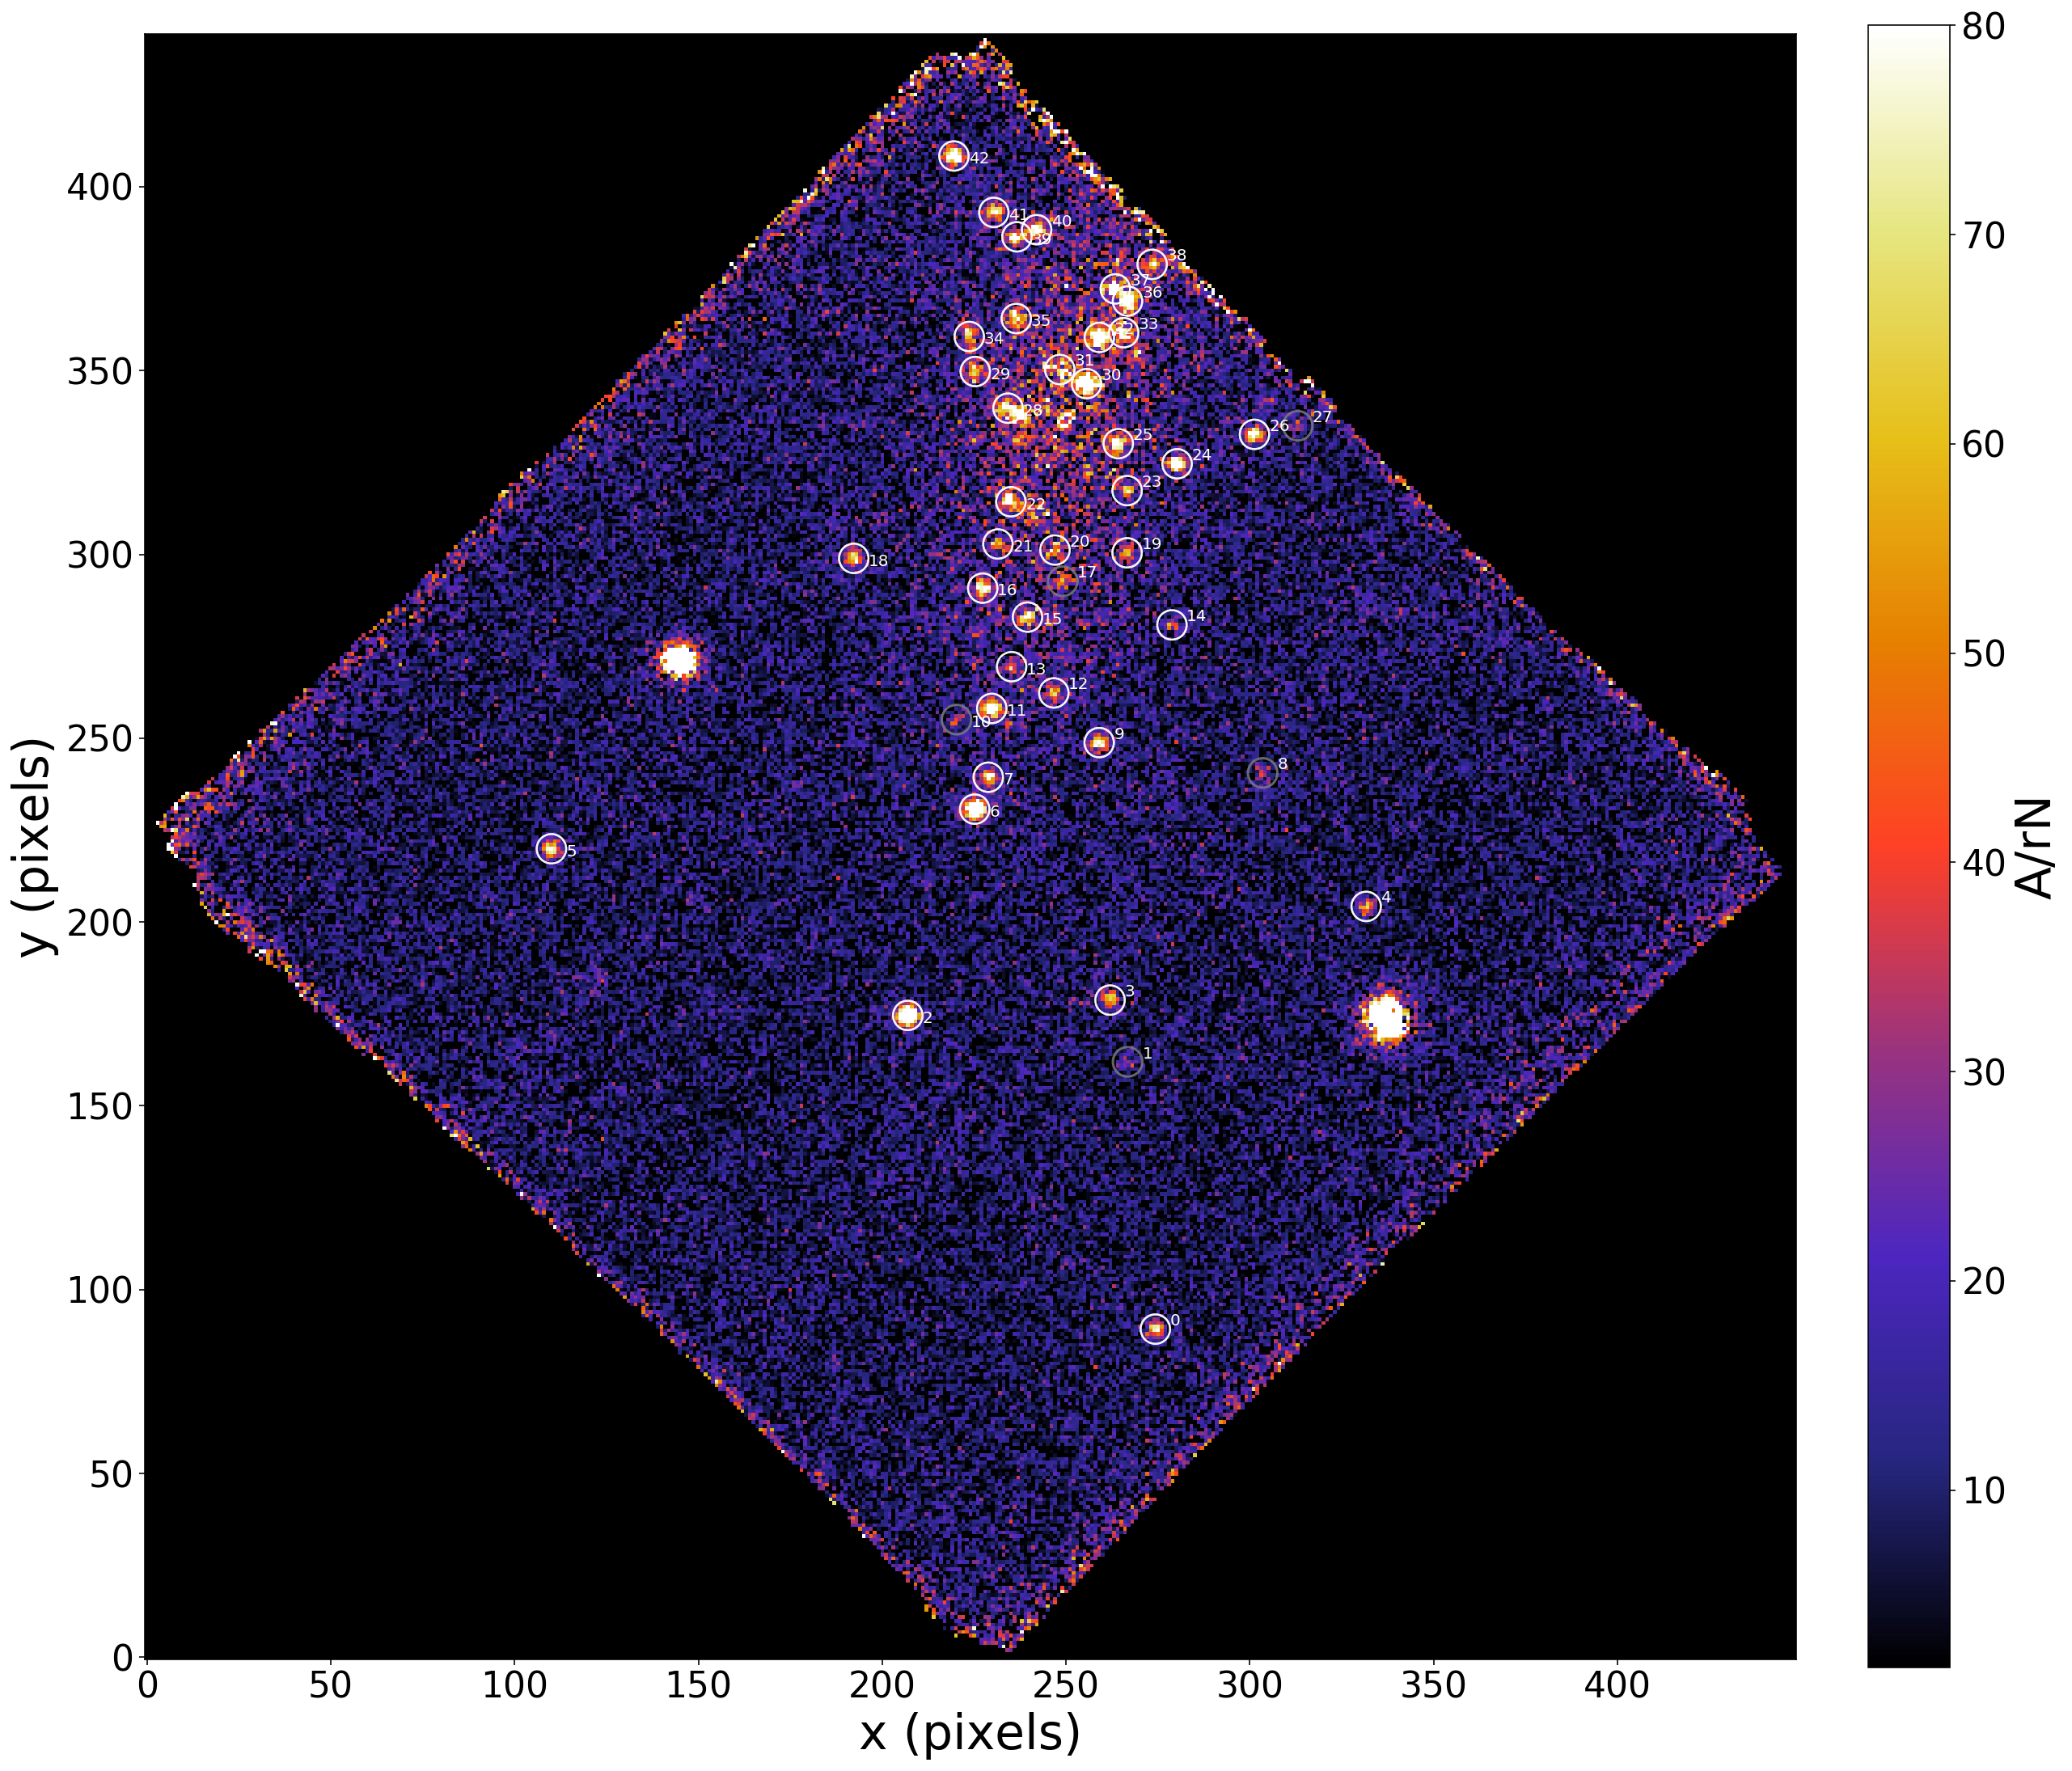

In [37]:

plt.figure(figsize=(20,20))
plt.imshow(Flux_1D_cube, origin="lower", cmap="CMRmap",  vmin=1.5, vmax=80)
#plt.imshow(Flux_1D_cube, origin="lower", cmap="CMRmap",  vmin=10, vmax=100)
ax = plt.gca()
cb=plt.colorbar(fraction=0.0455, pad=0.04)
cb.set_label("A/rN",fontsize=30)
cb.ax.tick_params(labelsize=22)

plt.xlabel("x (pixels)", fontsize=30)
plt.ylabel("y (pixels)", fontsize=30)

plt.tick_params(labelsize = 22)

Y, X = np.mgrid[:y_data, :x_data]
xe, ye, length, width, alpha = gal_mask

if gal_name=="FCC219":
    plt.ylim(0,440)
    plt.xlim(0,440)
elif gal_name=="FCC193":
    plt.ylim(250,)
    plt.xlim(0,350)
elif gal_name=="FCC161":
    plt.xlim(0,450)
elif gal_name=="FCC147":
    plt.xlim(230,)
    plt.ylim(0,320)
elif gal_name=="FCC083":
    plt.xlim(0,370)
    plt.ylim(0,370)

elip_gal = Ellipse((xe, ye), width, length, angle=alpha*(180/np.pi), fill=False, color="white", ls="--")
ax.add_artist(elip_gal)

for i, item in enumerate(x_y_list):
    if PNe_df.iloc[i].Filter == "Y":
        ax = plt.gca()
        circ = plt.Circle((item[0],item[1]),4, color="white",lw=1.2, fill=False, alpha=0.8)
        ax.add_artist(circ)
    elif PNe_df.iloc[i].Filter == "N":
        ax = plt.gca()
        circ = plt.Circle((item[0],item[1]),4, color="grey",lw=1.5, fill=False, alpha=0.8)
    ax.add_artist(circ)
    if item[0]<240.:
        ax.annotate(i, (item[0]+4, item[1]-2), color="white", size=10)
    else:
        ax.annotate(i, (item[0]+4, item[1]+1), color="white", size=10)

        
# for i in contamination:
#     ax = plt.gca()
#     circ = plt.Circle((x_PNe[i],y_PNe[i]),6, color="r",lw=1.0, fill=False, alpha=0.7)
#     ax.add_artist(circ)
    
#plt.axvline(190)
#plt.axhline(110)
#plt.savefig("Plots/"+gal_name+"/A_rN_circled.pdf", bbox_inches='tight')

# Scatter points for measured PNe velocity

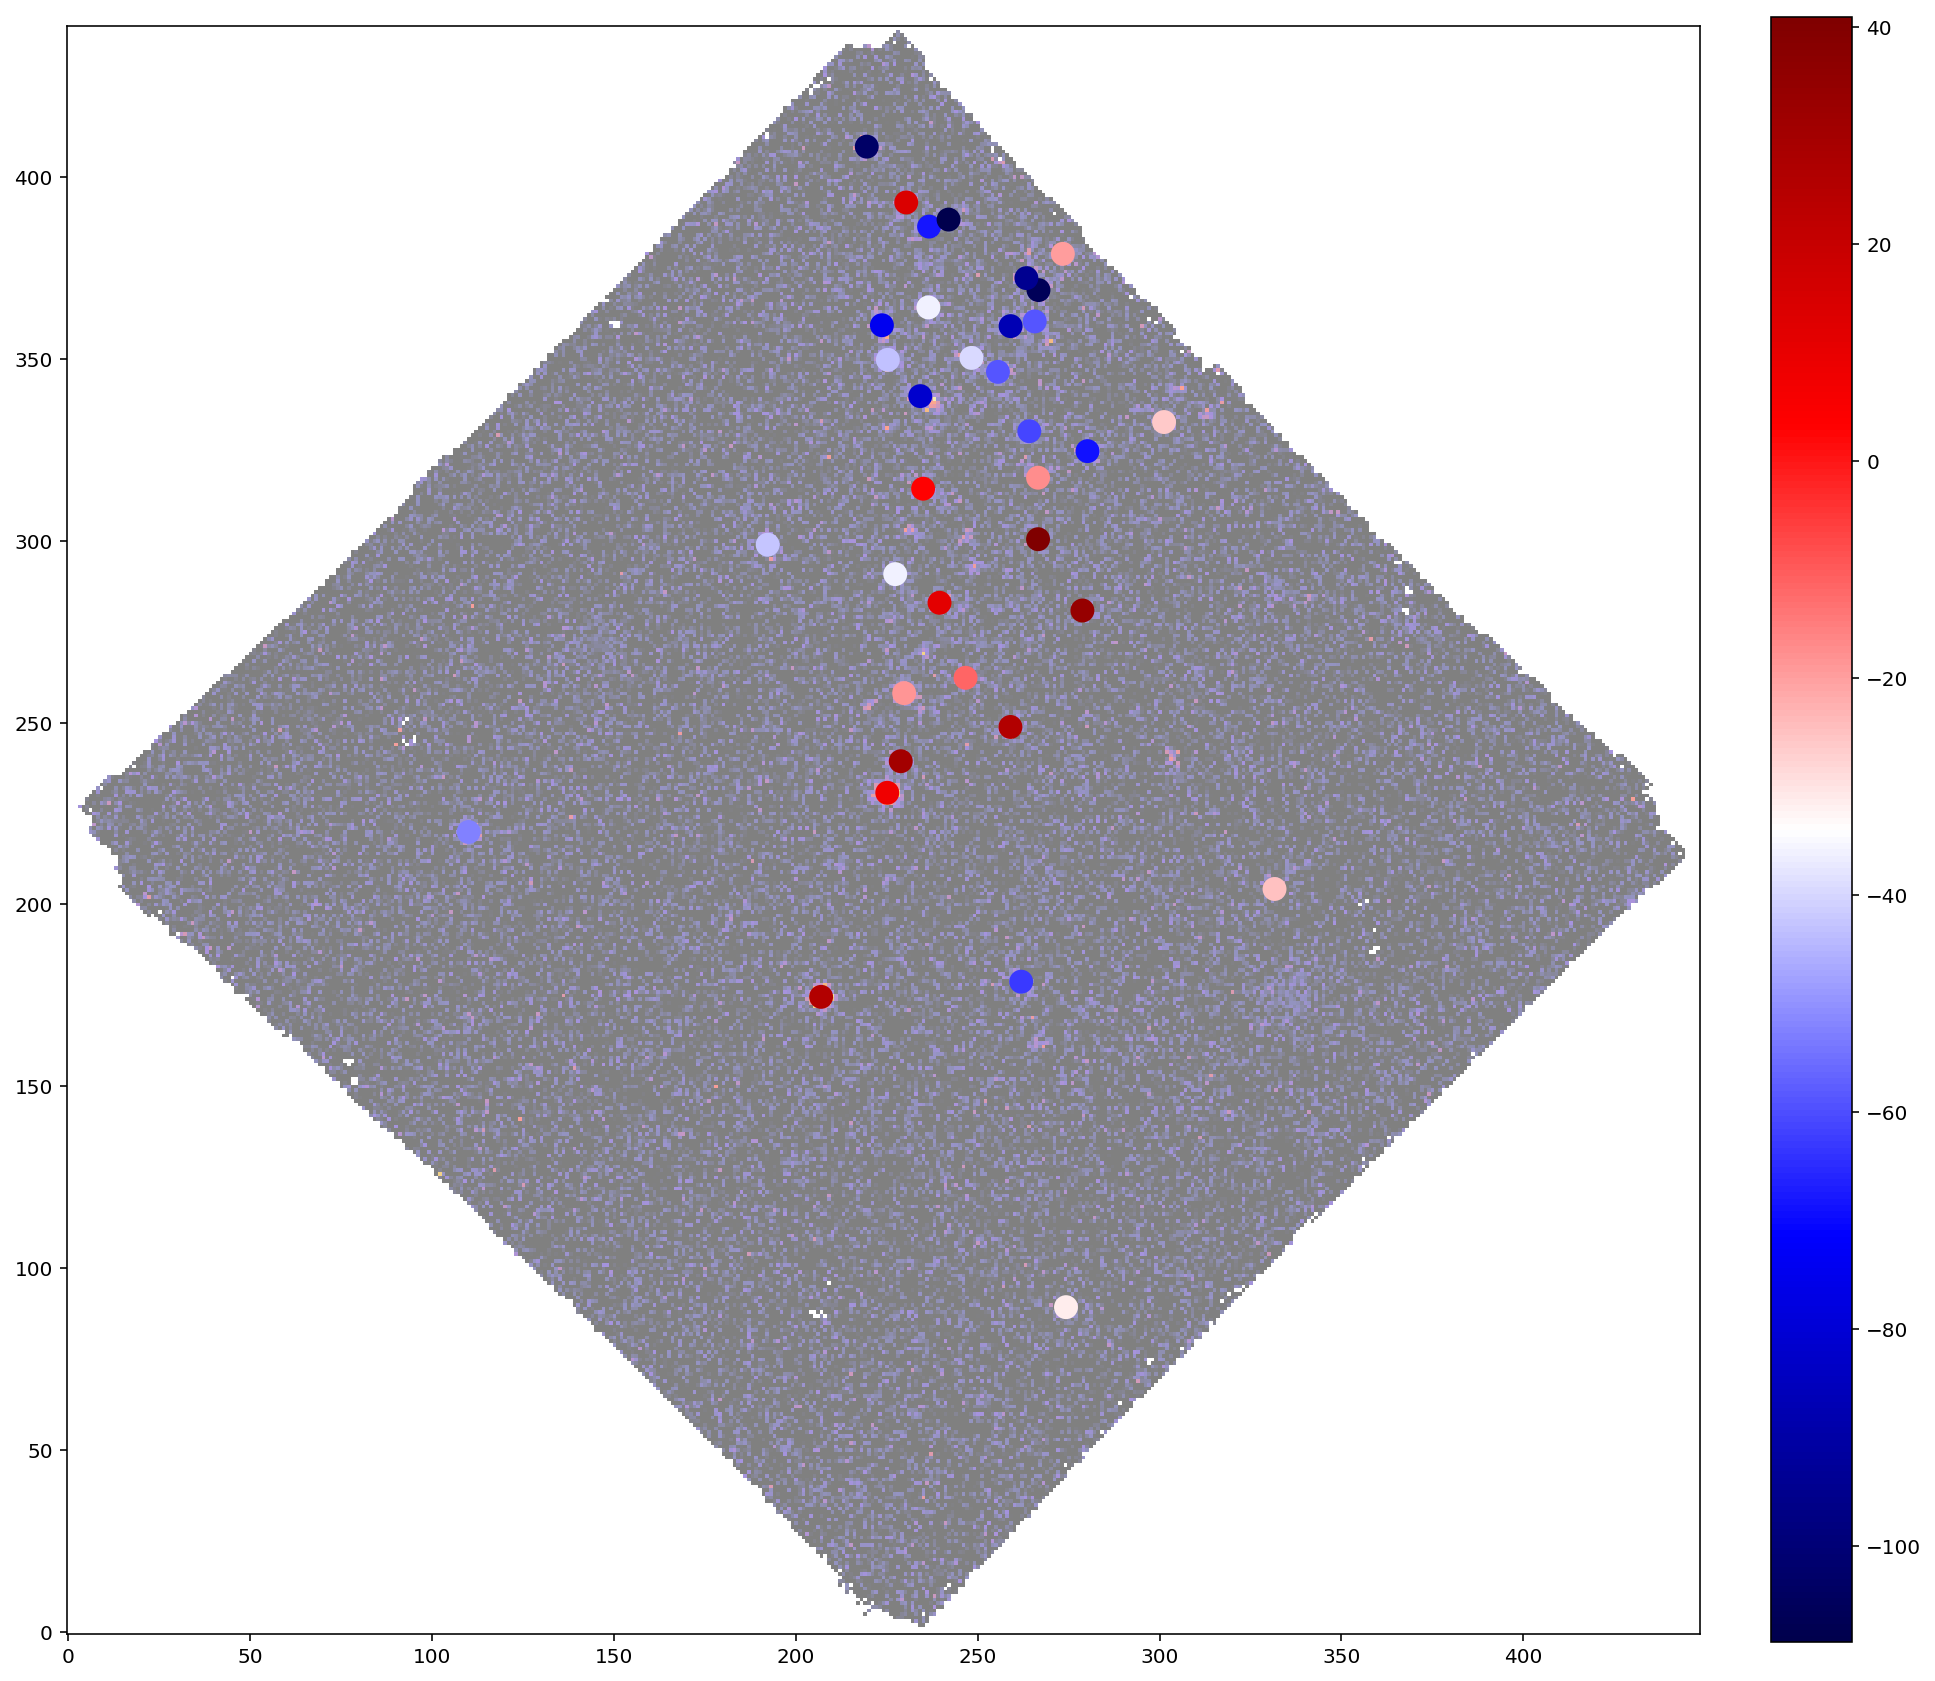

In [26]:
# Scatter plot the x y locations of PNe, colour coding them with their velocity
ind=PNe_df.loc[PNe_df["Filter"]=="Y"].index
positions = (x_PNe[ind], y_PNe[ind])
apertures = CircularAperture(positions, r=4)
plt.figure(figsize=(16,16))
plt.imshow(A_rN_plot_shape, origin="lower", cmap="CMRmap", vmin=1, vmax=8., alpha=0.5)
plt.scatter(x_PNe[ind], y_PNe[ind], c=PNe_df["V (km/s)"].loc[PNe_df["Filter"]=="Y"], cmap="seismic", s=120)
# plt.scatter(x_PNe, y_PNe, c=PNe_df["m 5007"], cmap="inferno_r", s=120)
if gal_name=="FCC219":
    plt.ylim(0,440)
    plt.xlim(0,440)
elif gal_name=="FCC193":
    plt.ylim(250,)
    plt.xlim(0,350)
cb = plt.colorbar(fraction=0.0455, pad=0.04)
# cb.set_label("$V_{[OIII]} \ (km \ s^{-1}$)", fontsize=20)
#plt.savefig("Plots/"+gal_name+"/PNe_velocity_dist_map.pdf")

In [101]:
## Velocity from files

hdulist_table = fits.open(gal_name+"_data/"+gal_name+"center_table.fits")
X_star, Y_star = hdulist_table[1].data.XBIN, hdulist_table[1].data.YBIN
flux_star = hdulist_table[1].data.FLUX

idx = flux_star.argmax()
X_star, Y_star = X_star-X_star[idx], Y_star-Y_star[idx]

hdulist_ppxf = fits.open(gal_name+"_data/"+gal_name+"center_ppxf_SPAXELS.fits")
v_star, s_star = hdulist_ppxf[1].data.V, hdulist_ppxf[1].data.SIGMA

cond = np.sqrt( (X_star)**2 + (Y_star)**2 ) <= 5.0
vsys = np.average(v_star[cond])
v_star = v_star-vsys

f_ind = PNe_df.loc[PNe_df["Filter"]=="Y"].index
if gal_name == "FCC167":
    gal_x_c = 230
    gal_y_c = 212
elif gal_name == "FCC219":
    gal_x_c = 190
    gal_y_c = 110
elif gal_name == "FCC193":
    gal_x_c = 170
    gal_y_c = 405

xpne, ypne = (x_PNe[f_ind]-gal_x_c)*0.2, (y_PNe[f_ind]-gal_y_c)*0.2

# Estimating the velocity dispersion of the PNe along the LoS
def sig_PNe(X_star,Y_star,v_stars,sigma,x_PNe,y_PNe,vel_PNe):

    d_PNe_to_skin = np.zeros(len(x_PNe))
    Vs_PNe = np.ones(len(x_PNe)) # Velocity of the closest star
    Ss_PNe = np.ones(len(x_PNe)) # Sigma for each PNe
    i_skin_PNe = []

    """ To estimate the velocity dispersion for PNe we need to
    extract the sigma of the closest stars for each PNe """

    for i in range(len(x_PNe)):
        r_tmp = np.sqrt((X_star-x_PNe[i])**2+(Y_star-y_PNe[i])**2)
        d_PNe_to_skin[i] = min(r_tmp)
        i_skin_PNe.append(r_tmp.argmin())

    Vs_PNe  = v_stars[i_skin_PNe]
    Ss_PNe  = sigma[i_skin_PNe]
    rad_PNe = np.sqrt(x_PNe**2+y_PNe**2)
    k = np.where(d_PNe_to_skin > 1.0)

    return rad_PNe, (vel_PNe-Vs_PNe)/Ss_PNe, k

rad_PNe, vel_ratio, k  = sig_PNe(X_star, Y_star, v_star, s_star, xpne, ypne, PNe_df["V (km/s)"].loc[PNe_df["Filter"]=="Y"])


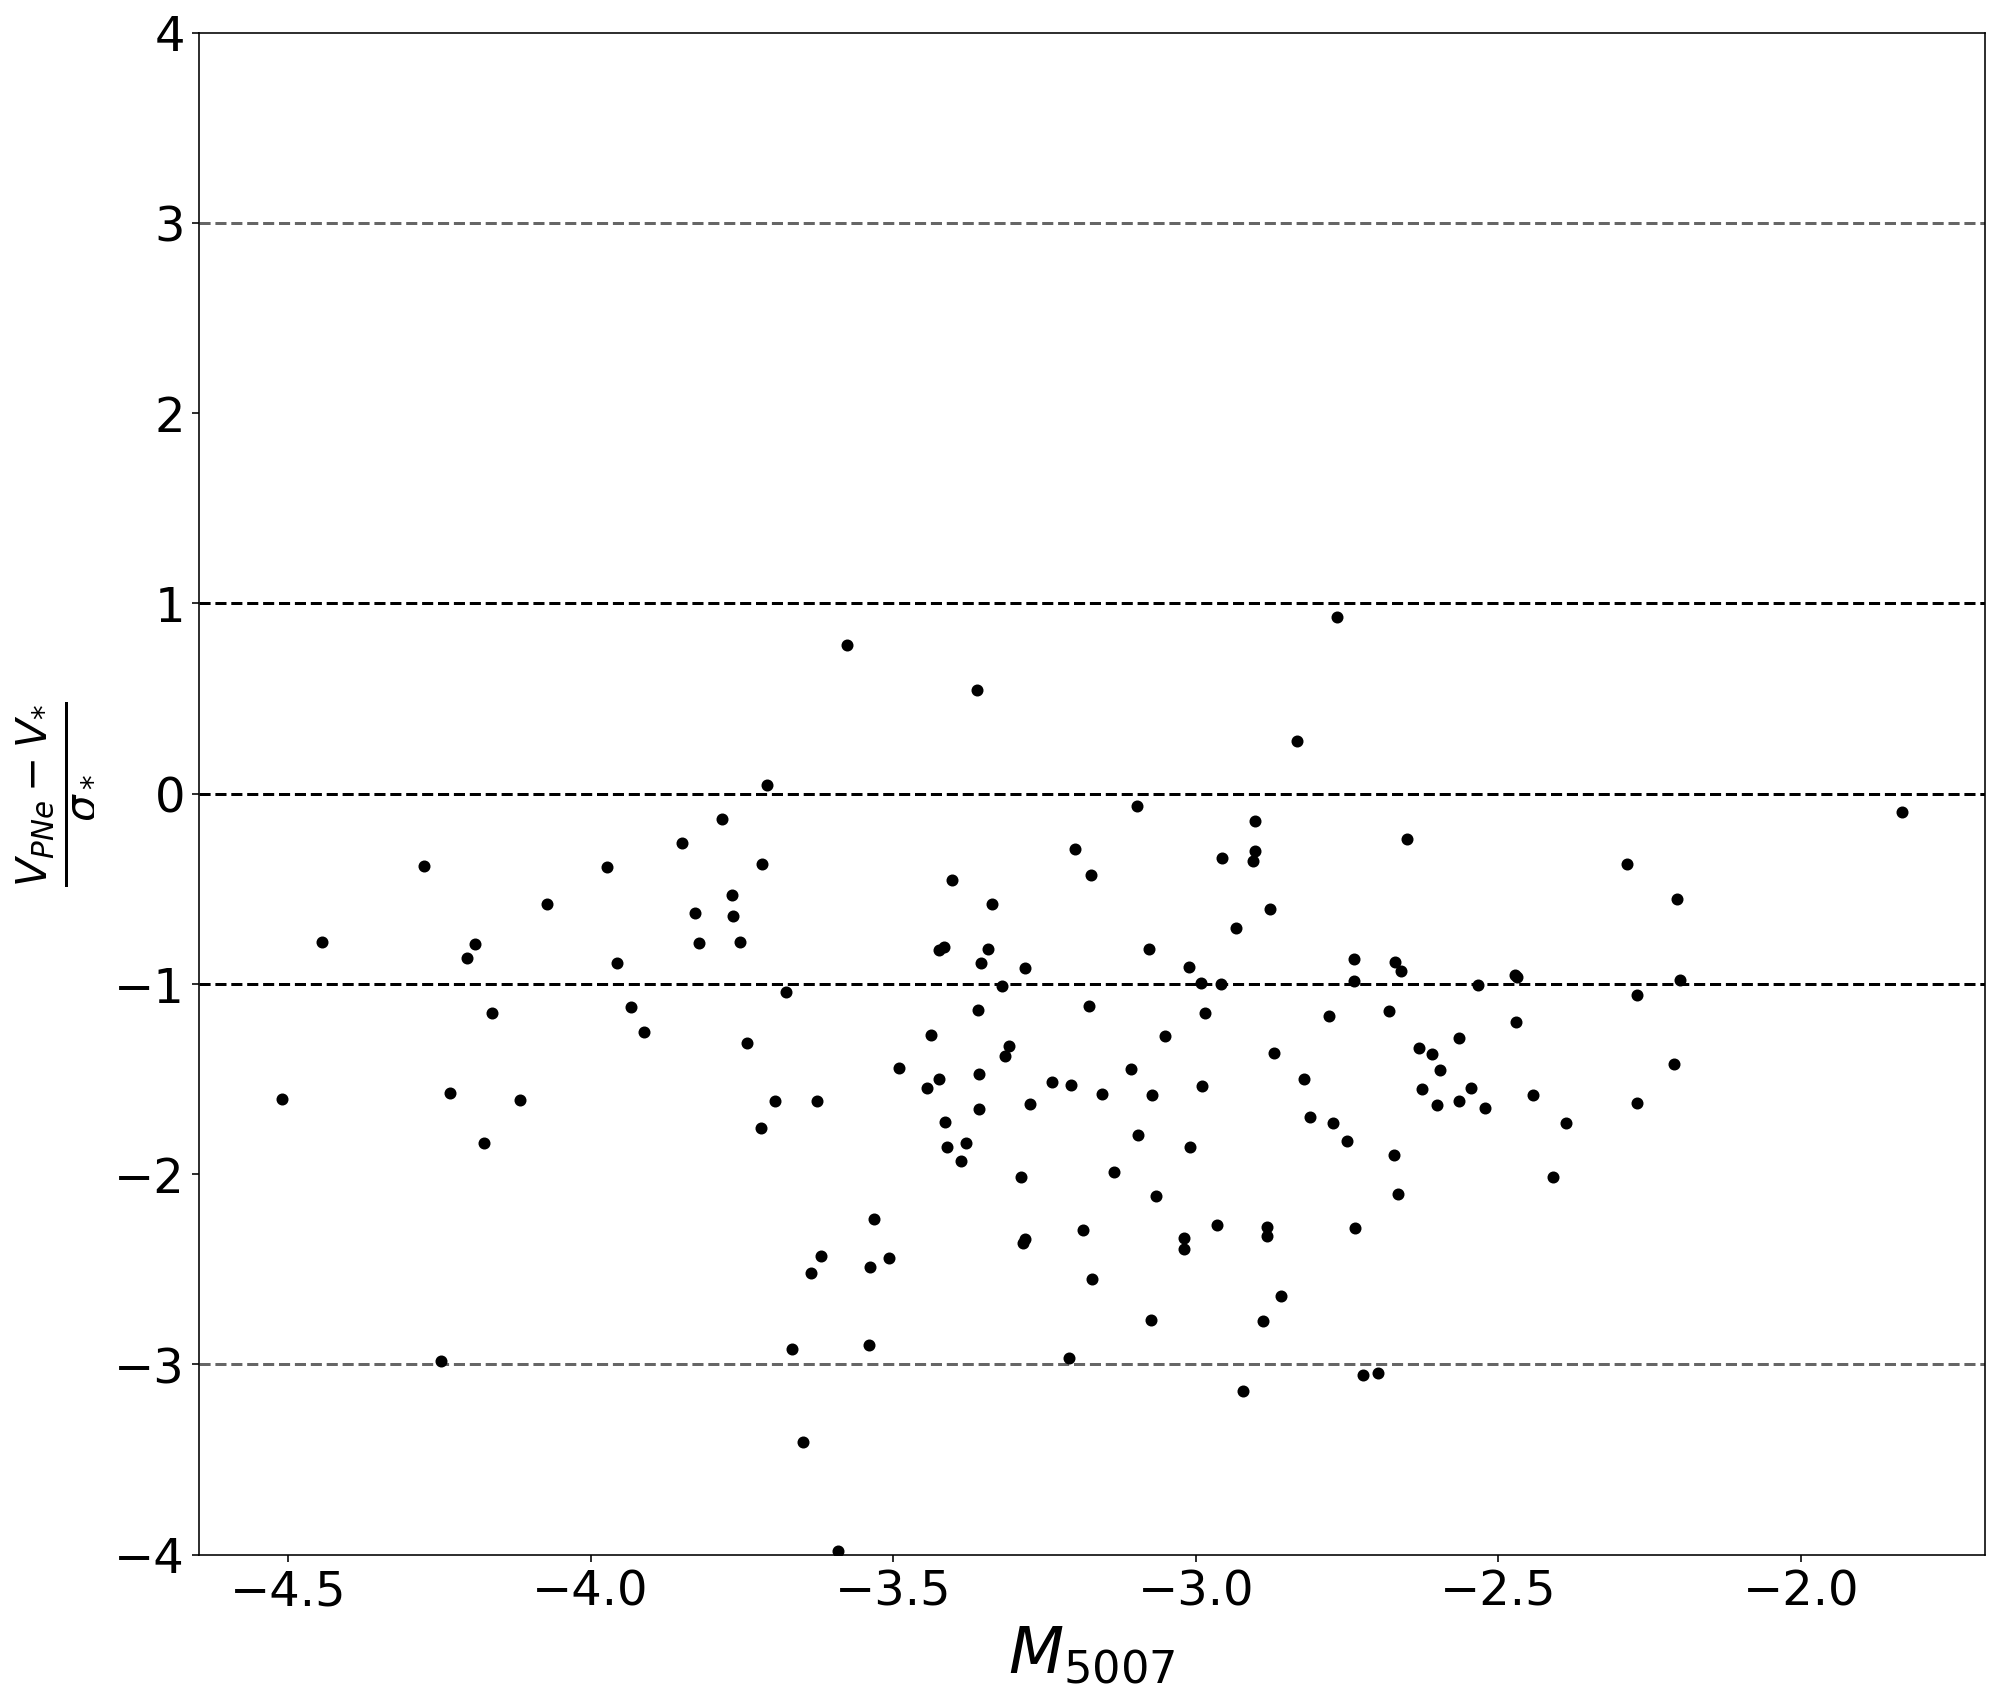

In [102]:
plt.figure(44, figsize=(16,14))
plt.clf()
plt.scatter(PNe_df["M 5007"].loc[PNe_df["Filter"]=="Y"], vel_ratio, s=25, c="k")
plt.xlabel("$M_{5007}$", fontsize=32)
plt.ylabel(r"$\frac{V_{PNe} - V_{*}}{\sigma_*}$", fontsize=30, labelpad=10)
plt.axhline(y=1, c="k", ls="dashed")
plt.axhline(y=3, c="k", ls="dashed", alpha=0.6)
plt.axhline(y=0, c="k", ls="dashed")
plt.axhline(y=-1, c="k", ls="dashed")
plt.axhline(y=-3, c="k", ls="dashed", alpha=0.6)
plt.ylim(-4,4)
plt.tick_params(labelsize = 24)
#plt.savefig("Plots/"+gal_name+"/"+gal_name+"_velocity_plot.pdf", bbox_inches='tight')

In [92]:
plt.figure(figsize=(16,16))
plt.scatter(X_star, Y_star, c=v_star, vmin=-150, vmax=150)
plt.scatter(xpne,ypne,c="r")
#plt.colorbar()

# SEP - Source Detection

In [17]:
A_rN_plot_shape[A_rN_plot_shape == A_rN_plot_shape[0,0]] = 0.0
plt.figure(figsize=(20,20))

Y, X = np.mgrid[:y_data, :x_data]
xe, ye, length, width, alpha = gal_mask #[170,180,70,45,2.3]

elip_mask_gal = (((X-xe) * np.cos(alpha) + (Y-ye) * np.sin(alpha)) / (width/2)) ** 2 + (((X-xe) * np.sin(alpha) - (Y-ye) * np.cos(alpha)) / (length/2)) ** 2 <= 1    

objects = sep.extract(A_rN_plot_shape, thresh=2.0, clean=True, mask=elip_mask_gal)
x_sep = objects["x"]
y_sep = objects["y"]

positions = (x_sep, y_sep)
apertures = CircularAperture(positions, r=4)
plt.figure(figsize=(16,16))
plt.imshow(A_rN_plot_shape, origin="lower", cmap="CMRmap", vmin=1, vmax=8.)
#plt.imshow(Flux_1D_cube, origin="lower", cmap="CMRmap", vmax=100)
apertures.plot(color="green")

#plt.xlim(0,370)
#plt.ylim(0,370)

ax = plt.gca()

elip_gal = Ellipse((xe, ye), width, length, angle=alpha*(180/np.pi), fill=False, color="white")
ax.add_artist(elip_gal)

sep_x_y_list = [[x,y] for x,y in zip(x_sep, y_sep)]
print(len(x_sep))

np.save("exported_data/"+gal_name+"/PNe_x_y_list", sep_x_y_list)

43


/local/tspriggs/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/local/tspriggs/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/local/tspriggs/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in less_equal
  import sys


<Figure size 1440x1440 with 0 Axes>

In [ ]:
## Tables for Marc
y_idx = PNe_df.loc[PNe_df["Filter"]=="Y"].index.values
n_idx = PNe_df.loc[PNe_df["Filter"]=="N"].index.values

tab_all = Table([PNe_df["PNe number"].values, 
                 PNe_df["A/rN"].values, 
                 PNe_df["Chi2"].values, 
                 A_2D_list[:,0], x_PNe, y_PNe, objects["peak"], mean_wave_list[:,0]], 
                names=("PNe #","fit A/rN", "Chi2", "A", "x", "y", "SEP A/rN", "best_fit_wave"))

tab_filter = Table([PNe_df["PNe number"].loc[PNe_df["Filter"]=="Y"], 
                    PNe_df["A/rN"].loc[PNe_df["Filter"]=="Y"].values, 
                    PNe_df["Chi2"].loc[PNe_df["Filter"]=="Y"].values, A_2D_list[y_idx,0], x_PNe[y_idx], y_PNe[y_idx], 
                    objects["peak"][y_idx], mean_wave_list[y_idx,0]], 
                   names=("PNe #","fit A/rN", "Chi2", "A", "x", "y", "SEP A/rN", "best_fit_wave"))

ascii.write(tab_all, "exported_data/"+gal_name+"/SEP_all_data_Table.dat", overwrite=True)
ascii.write(tab_filter, "exported_data/"+gal_name+"/SEP_filtered_data_Table.dat", overwrite=True)

# PSF

[ 2  6 11 42  5]
FWHM:  3.815994192790672 +/- 0.03990054233298397 (1.05%)
Beta:  2.9441997315062416 +/- 0.26435407129375843 (8.98%)
LSF:  2.7891736124851008 +/- 0.017937369739470462 (0.64%)




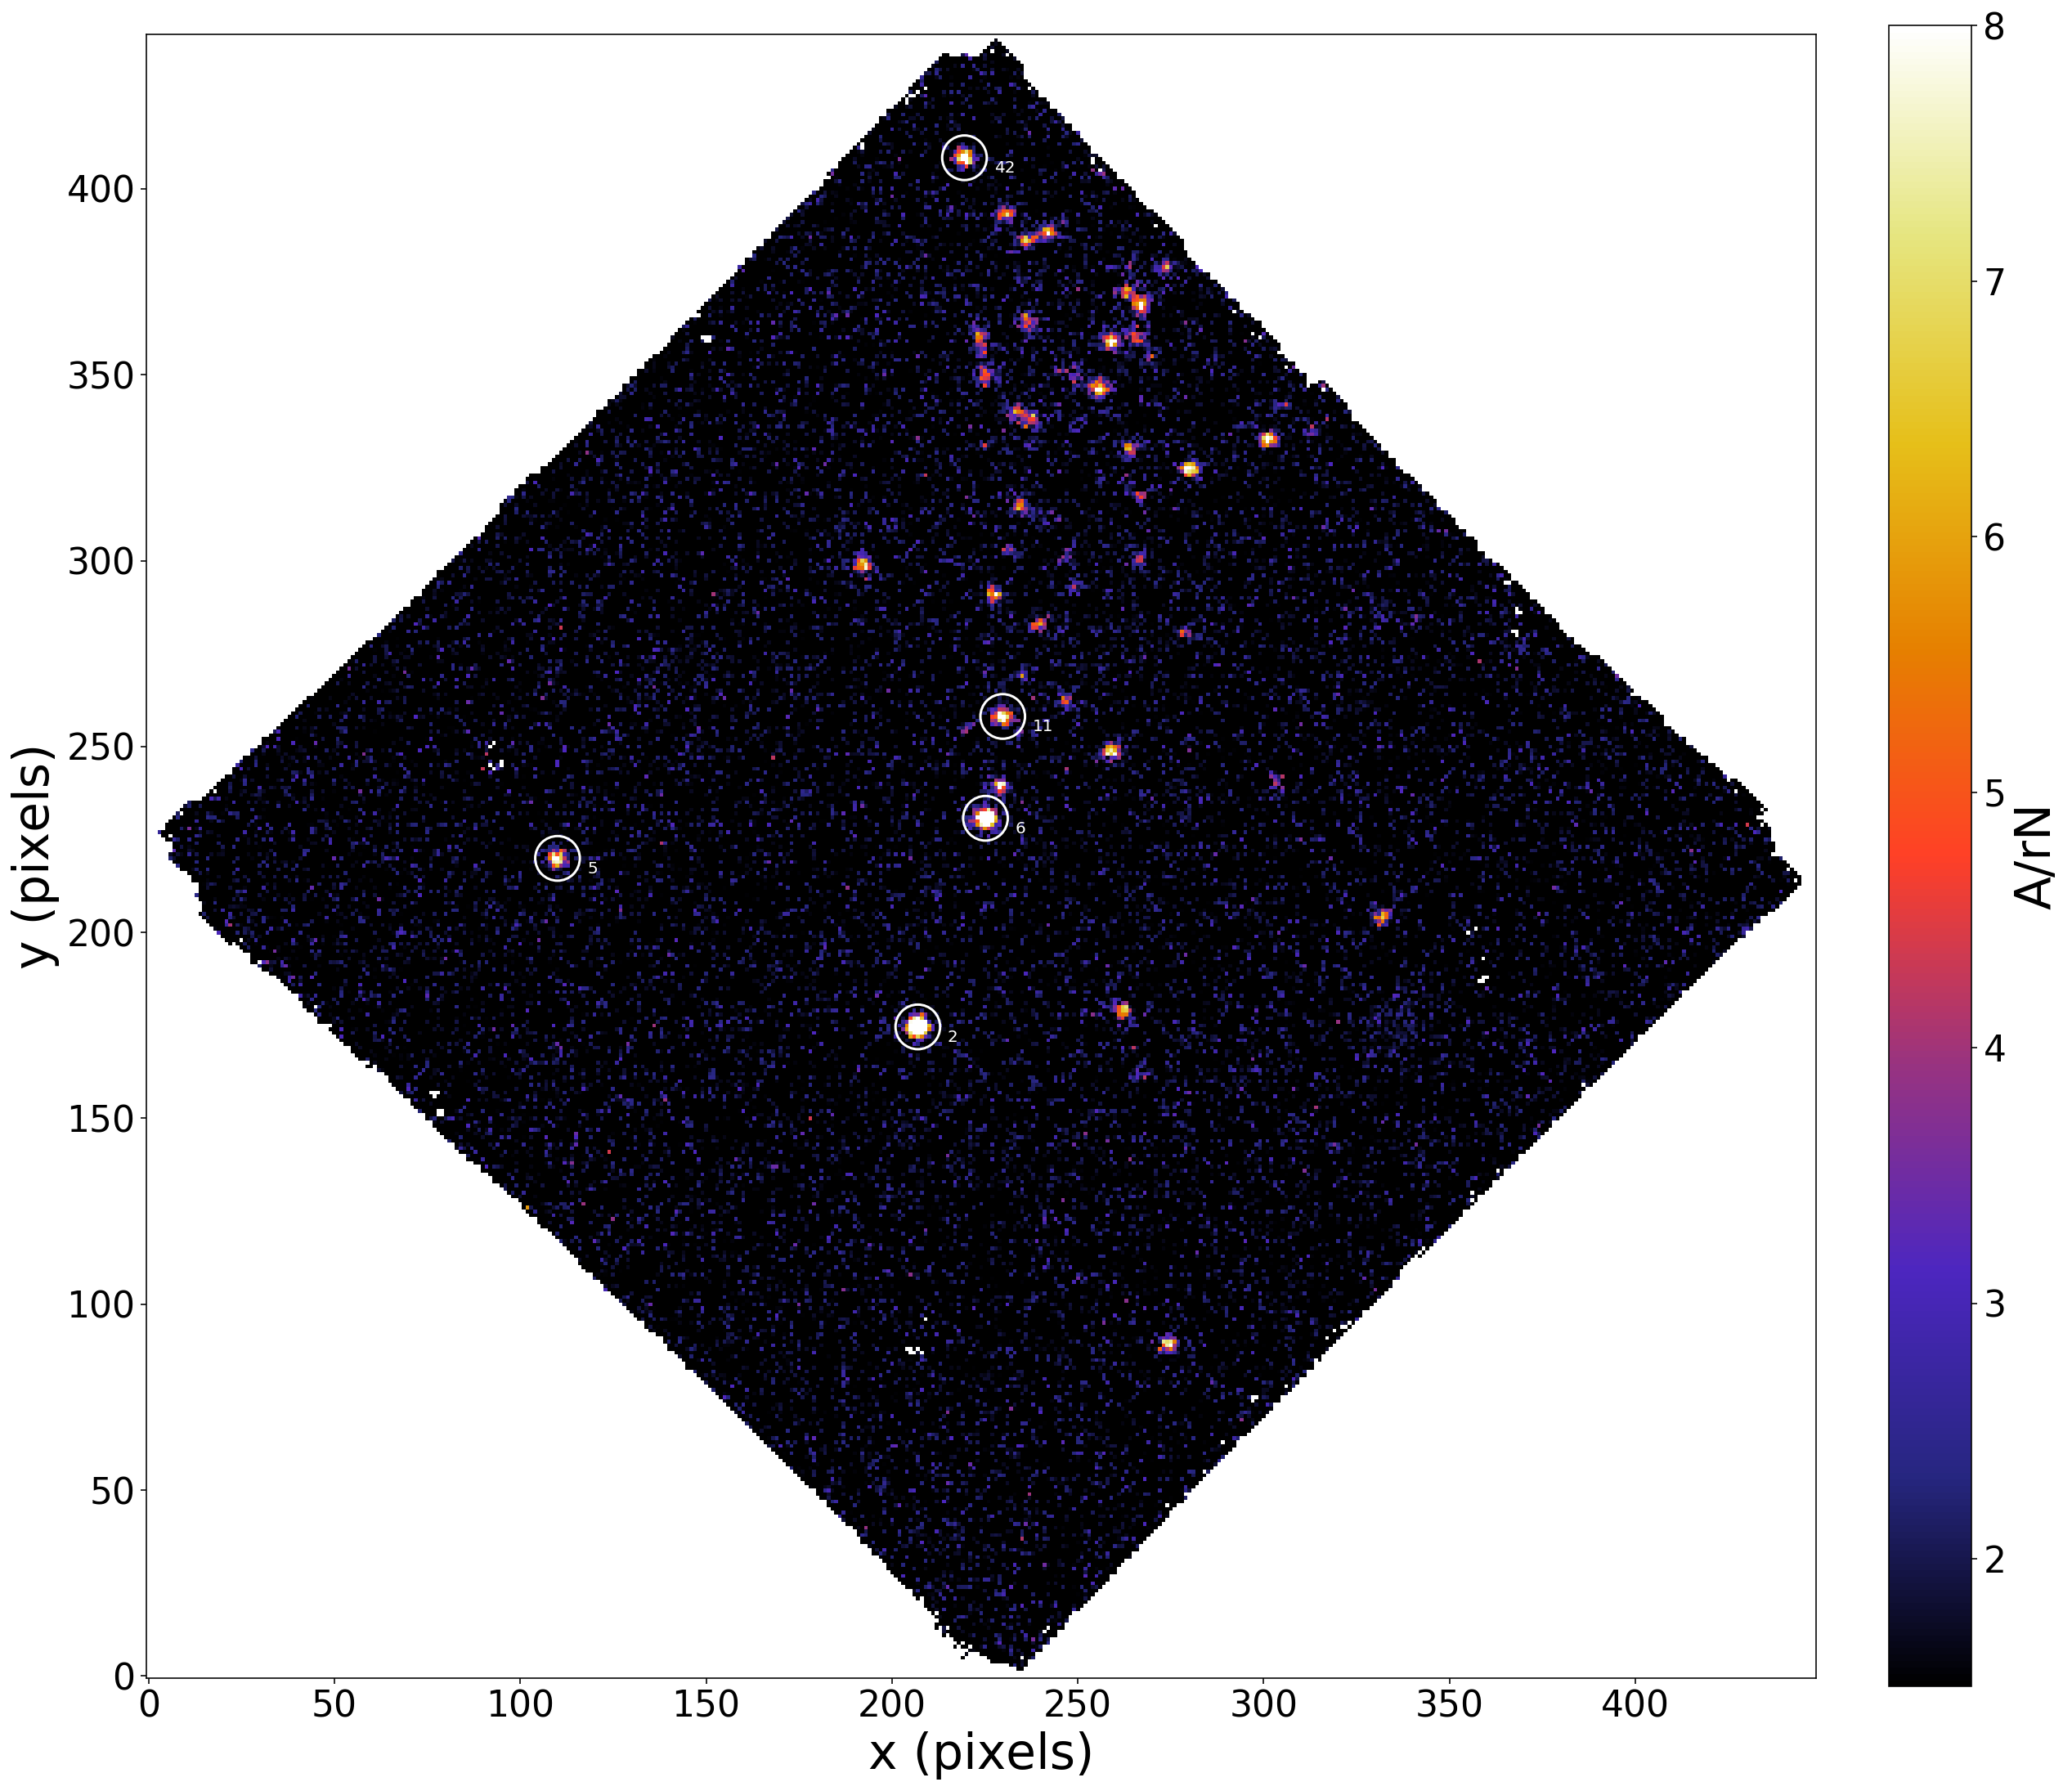

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 145
    # data points      = 75330
    # variables        = 23
    chi-square         = 1385171.60
    reduced chi-square = 18.3936633
    Akaike info crit   = 219384.425
    Bayesian info crit = 219596.707
[[Variables]]
    moffat_amp_000:  231.076129 +/- 2.21111935 (0.96%) (init = 200)
    x_000:           3.67259608 +/- 0.01843277 (0.50%) (init = 4.5)
    y_000:           3.99669181 +/- 0.01904554 (0.48%) (init = 4.5)
    wave_000:        5028.73898 +/- 0.01034932 (0.00%) (init = 5028.56)
    gauss_bkg_000:   0 (fixed)
    gauss_grad_000:  0 (fixed)
    moffat_amp_001:  202.747861 +/- 2.21576445 (1.09%) (init = 200)
    x_001:           3.72483320 +/- 0.02530860 (0.68%) (init = 4.5)
    y_001:           4.49330362 +/- 0.02522684 (0.56%) (init = 4.5)
    wave_001:        5028.44749 +/- 0.01390017 (0.00%) (init = 5028.56)
    gauss_bkg_001:   0 (fixed)
    gauss_grad_001:  0 (fixed)
    moffat_amp_002:  124.7

In [29]:
### Single Run PSF Fitter
#sel_PNe = PNe_df.nsmallest(4, "m 5007").index.values
if gal_name == "FCC167":
    sel_PNe = PNe_df.loc[PNe_df["Filter"]=="Y"].loc[PNe_df["PNe number"] != 122].nlargest(5, "A/rN").index.values
elif gal_name == "FCC219":
    sel_PNe = PNe_df.loc[PNe_df["Filter"]=="Y"].loc[PNe_df["PNe number"] != 30].nlargest(10, "A/rN").index.values
elif gal_name == "FCC193":
    sel_PNe = PNe_df.loc[PNe_df["Filter"]=="Y"].loc[PNe_df["PNe number"] != 38].nlargest(6, "A/rN").index.values
elif gal_name == "FCC161":
    sel_PNe = PNe_df.loc[PNe_df["Filter"]=="Y"].nlargest(7, "A/rN").index.values#.loc[PNe_df["PNe number"] != 38].
elif gal_name == "FCC147":
    #sel_PNe = PNe_df.loc[PNe_df["Filter"]=="Y"].loc[PNe_df["PNe number"] != 3].nlargest(5, "A/rN").index.values
    sel_PNe = [43,64,19,12,6]
elif gal_name == "FCC083":
    sel_PNe = PNe_df.loc[PNe_df["Filter"]=="Y"].loc[(PNe_df["PNe number"] != 42) & (PNe_df["PNe number"] != 63)].nlargest(8, "A/rN").index.values#.loc[PNe_df["PNe number"] != 38].
elif gal_name == "FCC255":
    sel_PNe = PNe_df.loc[PNe_df["Filter"]=="Y"].nlargest(5, "A/rN").index.values

#sel_PNe = PNe_df.loc[PNe_df["PNe number"] != 1].nlargest(10, "A/rN").index.values

#sel_PNe = [43,19,12,6]
print(sel_PNe)

selected_PNe = PNe_spectra[sel_PNe]
selected_PNe_err = obj_error_cube[sel_PNe]
PSF_params = Parameters()

def model_params(p, n, amp, mean):
    PSF_params.add("moffat_amp_{:03d}".format(n), value=amp, min=0.01)
    PSF_params.add("x_{:03d}".format(n), value=n_pixels/2., min=0.1, max=n_pixels)
    PSF_params.add("y_{:03d}".format(n), value=n_pixels/2., min=0.1, max=n_pixels)
    PSF_params.add("wave_{:03d}".format(n), value=mean, min=mean-50., max=mean+50.)
    PSF_params.add("gauss_bkg_{:03d}".format(n),  value=0.000, vary=False)
    PSF_params.add("gauss_grad_{:03d}".format(n), value=0.000, vary=False)


for i in np.arange(0,len(sel_PNe)):
        model_params(p=PSF_params, n=i, amp=200.0, mean=5007*(1+z))    
    
PSF_params.add('FWHM', value=4.0,  min=0.01, vary=True)
PSF_params.add("beta", value=2.5,  min=0.01, vary=True) 
PSF_params.add("LSF",  value=2.81,)# min=0.01, vary=True)

PSF_results = minimize(PSF_residuals_3D, PSF_params, args=(wavelength, x_fit, y_fit, selected_PNe, selected_PNe_err, z), nan_policy="propagate")

print("FWHM: ", PSF_results.params["FWHM"].value, "+/-", PSF_results.params["FWHM"].stderr, "({:3.2f}%)".format((PSF_results.params["FWHM"].stderr / PSF_results.params["FWHM"].value)*100) )
print("Beta: ", PSF_results.params["beta"].value, "+/-", PSF_results.params["beta"].stderr, "({:3.2f}%)".format((PSF_results.params["beta"].stderr / PSF_results.params["beta"].value)*100) )
print("LSF: " , PSF_results.params["LSF"].value , "+/-", PSF_results.params["LSF"].stderr,  "({:3.2f}%)".format((PSF_results.params["LSF"].stderr  / PSF_results.params["LSF"].value)*100)  )
print("\n")

# Plot locations of PNe used for PSF
plt.figure(figsize=(20,20))
plt.imshow(A_rN_plot_shape, origin="lower", cmap="CMRmap",  vmin=1.5, vmax=8)
ax = plt.gca()
cb=plt.colorbar(fraction=0.0455, pad=0.04)
cb.set_label("A/rN",fontsize=30)
cb.ax.tick_params(labelsize=22)

plt.xlabel("x (pixels)", fontsize=30)
plt.ylabel("y (pixels)", fontsize=30)

plt.tick_params(labelsize = 22)

#plt.xlim(0,370)
#plt.ylim(0,370)

for (i, item), n in zip(enumerate(x_y_list[sel_PNe]), sel_PNe):
    ax = plt.gca()
    circ = plt.Circle((item[0],item[1]),6, color="white",lw=1.5, fill=False)
    ax.add_artist(circ)
    if item[0]<240.:
        ax.annotate(n, (item[0]+8, item[1]-4), color="white", size=10)
    else:
        ax.annotate(n, (item[0]+8, item[1]+2), color="white", size=10)

plt.show()
print(report_fit(PSF_results, show_correl=False))


## Comparison with literature

In [61]:
gal_hdulist = fits.open(gal_name+"_data/"+gal_name+"center.fits")

x_y_list = np.load("exported_data/"+gal_name+"/PNe_x_y_list.npy")
x_PNe = np.array([x[0] for x in x_y_list])
y_PNe = np.array([y[1] for y in x_y_list])

hdr_wcs = gal_hdulist[1].header
wcs_obj = WCS(hdr_wcs, naxis=2)

for i in np.arange(0, len(x_PNe)):
    Ra_Dec = utils.pixel_to_skycoord(x_PNe[i],y_PNe[i], wcs_obj).to_string("hmsdms").split()
    PNe_df.loc[i,"Ra (J2000)"] = Ra_Dec[0]
    PNe_df.loc[i,"Dec (J2000)"] = Ra_Dec[1]

## FCC167

In [51]:
c = ascii.read("NGC1380_PNe_from_paper.txt", data_start=1)
lit_RA = list(c["RA"])
lit_Dec = list(c["Dec"])
lit_m = np.array(c["mag"])

x_y_lit = np.ones((len(x_PNe),2))
for i in np.arange(0, len(lit_RA)):
    x_y_lit[i] = utils.skycoord_to_pixel(SkyCoord(ra=Angle(lit_RA[i], u.hourangle), dec=Angle(lit_Dec[i], u.deg), frame="fk5"), wcs_obj)

smallest_sep = []
for r,d in zip(lit_RA, lit_Dec):
    sepa = []
    for r1,d1 in zip(PNe_df["Ra (J2000)"], PNe_df["Dec (J2000)"]):
        c1 = SkyCoord(Angle(r, u.hourangle), Angle(d, u.deg), frame="fk5")
        c2 = SkyCoord(Angle(r1, u.hourangle), Angle(d1, u.deg), frame="fk5")
        sepa.append(c1.separation(c2).degree)
    smallest_sep.append(sepa)
    
diff = np.array([np.min(smallest_sep[i]) for i in range(0, len(smallest_sep))])
potential_diff = diff[diff<0.001]
print(potential_diff)
print(np.where(diff<0.001))

indx =np.array(([np.squeeze(np.where(smallest_sep[i] == np.min(smallest_sep[i]))) for i in range(0, len(smallest_sep))]))
#print(indx[[0,2,6,20]])
#print(lit_m[[0,2,6,20]])
PNe_df.loc[indx[np.where(diff<0.001)]]

[0.0001147  0.00099191 0.00032357 0.00041565 0.00027396]
(array([ 0,  1,  2,  6, 20]),)


PNe number      Ra (J2000)      Dec (J2000)    V (km/s)     m 5007  \
105         105  03h36m27.6516s  -34d58m00.2475s -162.572831  27.870699   
107         107  03h36m28.2602s  -34d57m57.1921s -145.570366  27.659577   
93           93  03h36m28.0016s  -34d58m14.8502s -110.938476  26.852739   
66           66  03h36m26.3736s  -34d58m29.4728s   12.141866  27.159870   
85           85  03h36m25.6455s  -34d58m18.9537s  -99.128209  27.535839   

       M 5007   [OIII] Flux M 5007 error      A/rN rad D    redchi Filter  \
105 -3.760980  2.268404e-17          NaN  4.177366   NaN  1.031042      Y   
107 -3.972102  2.755302e-17          NaN  3.353217   NaN  1.022538      Y   
93  -4.778940  5.793010e-17          NaN  7.411431   NaN  1.022187      Y   
66  -4.471809  4.365681e-17          NaN  6.180837   NaN  1.026172      Y   
85  -4.095841  3.087909e-17          NaN  5.811747   NaN  1.032757      Y   

     [OIII]/Hb    Flux error  F[OIII] err percent    OIII/Ha  
105   6.335699  1.300286e-18             5.732164   4.407040  
107   4.995429  1.805498e-18             6.552813   0.000000  
93    3.922341  2.214920e-18             3.823436   9.842604  
66    8.170374  1.930254e-18             4.421427   8.790239  
85    5.690026  1.385662e-18             4.487380  11.094197

In [68]:
print(PNe_df["[OIII] Flux"].loc[indx[[ 0,  1,  2,  6, 20]]].values)
print([27.12196, 27.65957713, 26.85273923, 27.15986999, 27.53583866])
print(lit_m[[ 0,  1,  2,  6, 20]])
print(np.abs([27.12196, 27.65957713, 26.85273923, 27.15986999, 27.53583866] - lit_m[[ 0,  1,  2,  6, 20]]))

[2.26840373e-17 2.75530161e-17 5.79301040e-17 4.36568107e-17
 3.08790930e-17]
[27.12196, 27.65957713, 26.85273923, 27.15986999, 27.53583866]
[26.585 26.718 26.725 26.809 27.203]
[0.53696    0.94157713 0.12773923 0.35086999 0.33283866]


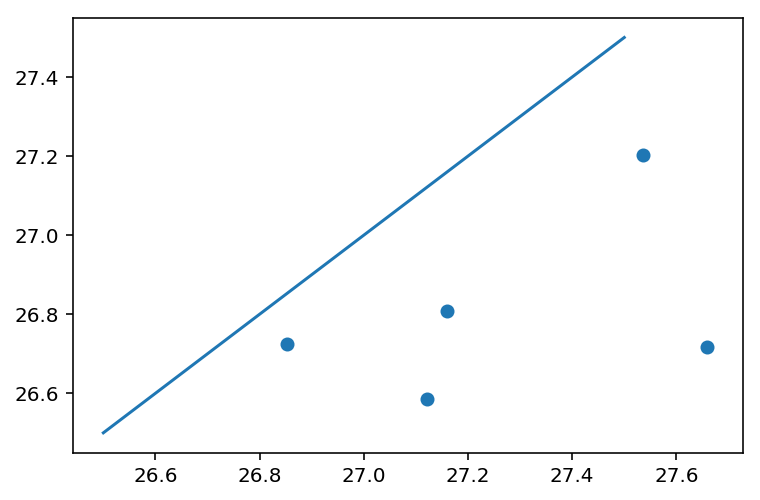

In [61]:
plt.scatter([27.12196, 27.65957713, 26.85273923, 27.15986999, 27.53583866], lit_m[[ 0,  1,  2,  6, 20]] )
plt.plot(np.arange(26.5,28), np.arange(26.5,28))

In [40]:
gauss_1D_A = np.load("exported_data/"+gal_name+"/gauss_A_cen.npy")
A_rN_plot = np.load("exported_data/"+gal_name+"/A_rN_cen.npy")

gauss_A_shape = gauss_1D_A.reshape(y_data, x_data)
rN = np.load("exported_data/"+gal_name+"/rN.npy")
rN_shape = rN.reshape(y_data,x_data)
#rN_shape[np.isnan(rN_shape)] = 0

Flux_1D = gauss_1D_A * np.sqrt(2*np.pi) * 1.19
Flux_1D_cube = Flux_1D.reshape(y_data, x_data)
A_rN_plot_shape = A_rN_plot.reshape(y_data, x_data)


fig = plt.figure(figsize=(20,20))
# fig.add_subplot(111, projection=wcs_obj)
plt.imshow(A_rN_plot_shape, origin='lower', cmap=plt.cm.viridis, vmin=1, vmax=8)
plt.scatter([x_y_lit[i][0] for i in range(len(x_y_lit))], [x_y_lit[i][1] for i in range(len(x_y_lit))], color="r", alpha=0.6)
plt.xlim(0,450)
plt.ylim(0,450)
plt.xlabel('RA')
plt.ylabel('Dec')

Text(0, 0.5, 'Dec')

## FCC219

In [62]:
PNe_hdulist = fits.open("PNe1404.fit")
list_1404 = PNe_hdulist[1].data
list_1404 = list_1404[-47:]
RA_1404 =    [list_1404[i][7] for i in np.arange(0,len(list_1404))]
Dec_1404 =   [list_1404[i][8] for i in np.arange(0,len(list_1404))]
m5007_1404 = [list_1404[i][4] for i in np.arange(0,len(list_1404))]

x_y_lit = np.ones((len(x_PNe),2))
for i in np.arange(0, len(list_1404)):
    x_y_lit[i] = utils.skycoord_to_pixel(SkyCoord(ra=Angle(RA_1404[i], u.hourangle), dec=Angle(Dec_1404[i], u.deg), frame="fk5"), wcs_obj)


gauss_1D_A = np.load("exported_data/"+gal_name+"/gauss_A_cen.npy")
A_rN_plot = np.load("exported_data/"+gal_name+"/A_rN_cen.npy")

gauss_A_shape = gauss_1D_A.reshape(y_data, x_data)
rN = np.load("exported_data/"+gal_name+"/rN.npy")
rN_shape = rN.reshape(y_data,x_data)
#rN_shape[np.isnan(rN_shape)] = 0

Flux_1D = gauss_1D_A * np.sqrt(2*np.pi) * 1.19
Flux_1D_cube = Flux_1D.reshape(y_data, x_data)
A_rN_plot_shape = A_rN_plot.reshape(y_data, x_data)


fig = plt.figure(figsize=(20,20))
# fig.add_subplot(111, projection=wcs_obj)
plt.imshow(A_rN_plot_shape, origin='lower', cmap=plt.cm.viridis, vmin=1, vmax=8)
plt.scatter([x_y_lit[i][0] for i in range(len(x_y_lit))], [x_y_lit[i][1] for i in range(len(x_y_lit))], color="r", alpha=0.6)
#plt.xlim(0,500)
#plt.ylim(0,500)
plt.xlabel('RA')
plt.ylabel('Dec')


smallest_sep = []
for r,d in zip(RA_1404, Dec_1404):
    sepa = []
    for r1,d1 in zip(PNe_df["Ra (J2000)"], PNe_df["Dec (J2000)"]):
        c1 = SkyCoord(Angle(r, u.hourangle), Angle(d, u.deg), frame="fk5")
        c2 = SkyCoord(Angle(r1, u.hourangle), Angle(d1, u.deg), frame="fk5")
        sepa.append(c1.separation(c2).degree)
    smallest_sep.append(sepa)
    
diff = np.array([np.min(smallest_sep[i]) for i in range(0, len(smallest_sep))])
potential_diff = diff[diff<0.001]
print(potential_diff)
print(np.where(diff<0.001))

indx =np.array(([np.squeeze(np.where(smallest_sep[i] == np.min(smallest_sep[i]))) for i in range(0, len(smallest_sep))]))
print(indx[np.where(diff<0.001)])
PNe_df.iloc[indx[np.where(diff<0.001)]]

[0.00027301 0.00022469 0.00024347 0.00022385 0.00019106 0.00024302]
(array([ 2,  4,  7, 31, 38, 43]),)
[ 61  65 104 115 106 108]


PNe number      Ra (J2000)      Dec (J2000)    V (km/s)     m 5007  \
61           61  03h38m49.0891s  -35d35m23.1532s -345.749869  27.594658   
65           65  03h38m48.9907s  -35d35m22.6009s  259.714851  28.093634   
104         104  03h38m50.0742s  -35d35m05.5478s -355.745398  27.353643   
115         115  03h38m52.1549s  -35d34m51.6173s -451.130710  27.669189   
106         106  03h38m53.8059s  -35d35m02.6063s -259.321397  28.158646   
108         108  03h38m49.5297s  -35d35m02.8763s   19.354254  27.316820   

       M 5007   [OIII] Flux M 5007 error       A/rN rad D    redchi Filter  \
61  -3.613009  2.925075e-17          NaN   7.341989   NaN  1.004045      Y   
65  -3.114033  1.847339e-17          NaN   4.815129   NaN  1.016195      Y   
104 -3.854023  3.652100e-17          NaN   9.963678   NaN  1.000426      Y   
115 -3.538478  2.731017e-17          NaN   7.054721   NaN  1.005559      Y   
106 -3.049021  1.739970e-17          NaN   4.337599   NaN  1.173099      Y   
108 -3.890847  3.778087e-17          NaN  10.563127   NaN  0.990047      Y   

             Chi2    [OIII]/Hb    Flux error  m 5007 error  \
61   15208.266245    25.372080           NaN           NaN   
65   15392.299328  9228.714999  8.123179e-19      0.047790   
104  15153.451480    32.677308           NaN           NaN   
115  15231.197990    23.703255           NaN           NaN   
106  17768.931222    15.369281           NaN           NaN   
108  14996.239947     1.216463  1.039995e-18      0.029875   

     F[OIII] err percent  
61                   NaN  
65              4.397234  
104                  NaN  
115                  NaN  
106                  NaN  
108             2.752703

(24, 31)

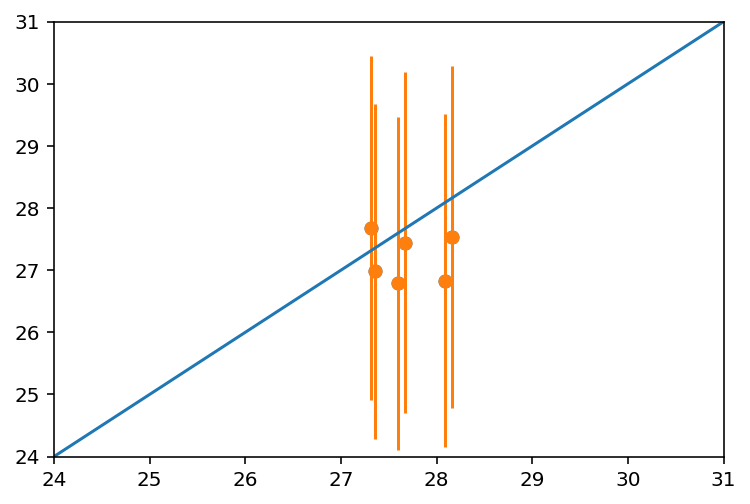

In [63]:
plt.figure()
plt.scatter(PNe_df["m 5007"].iloc[indx[np.where(diff<0.001)]].values, np.array(m5007_1404)[[np.where(diff<0.001)]])
plt.plot(np.arange(24,32), np.arange(24,32))
y_10_per = 10*(np.array(m5007_1404)[np.where(diff<0.001)]/100)
x_err = PNe_df["m 5007 error"].iloc[indx[np.where(diff<0.001)]].values
x_dat = PNe_df["m 5007"].iloc[indx[np.where(diff<0.001)]].values
y_dat = np.array(m5007_1404)[np.where(diff<0.001)]
plt.errorbar(x_dat, y_dat, yerr=y_10_per, xerr=x_err, fmt="o")
plt.xlim(24,31)
plt.ylim(24,31)

Text(0.5, 0, '$m_{5007} $ values MUSE')

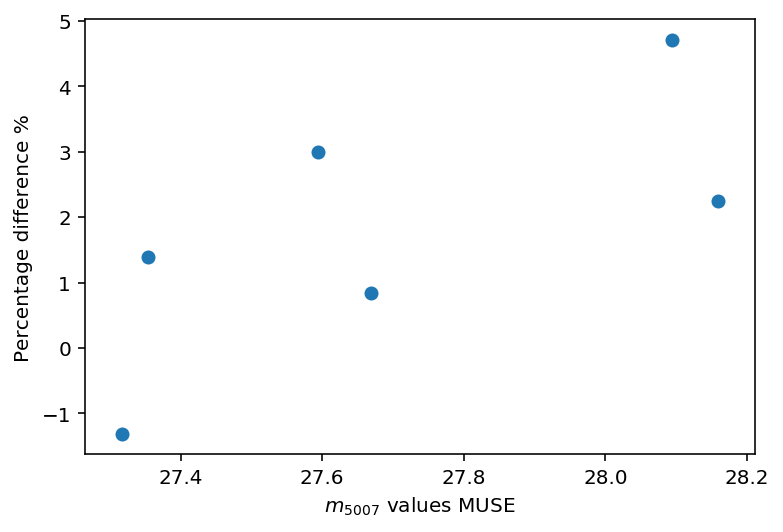

In [70]:
y_d = 100*((x_dat - y_dat)/y_dat)
x_d = 100*((y_dat-x_dat)/x_dat)

plt.scatter(x_dat, y_d)
plt.ylabel("Percentage difference %")
plt.xlabel("$m_{5007} $ values MUSE")

## Completeness testing

In [39]:
Dist_est

21.661190259052997

/auto/data/tspriggs/Github/MUSE_PNe_fitting/PNLF.py:60: RuntimeWarning: invalid value encountered in true_divide
  u2 = (d/(9.0*mad))**2  # c = 9
/auto/data/tspriggs/Github/MUSE_PNe_fitting/PNLF.py:61: RuntimeWarning: invalid value encountered in less
  good = u2 < 1.0
/auto/data/tspriggs/Github/MUSE_PNe_fitting/PNLF.py:65: RuntimeWarning: invalid value encountered in double_scalars
  sigma = np.sqrt(num/(den*(den - 1.0)))  # see note in above reference
/auto/data/tspriggs/Github/MUSE_PNe_fitting/PNLF.py:83: RuntimeWarning: divide by zero encountered in true_divide
  elip_mask_gal = (((X-xe) * np.cos(alpha) + (Y-ye) * np.sin(alpha)) / (width/2)) ** 2 + (((X-xe) * np.sin(alpha) - (Y-ye) * np.cos(alpha)) / (length/2)) ** 2 <= 1
/auto/data/tspriggs/Github/MUSE_PNe_fitting/PNLF.py:83: RuntimeWarning: invalid value encountered in true_divide
  elip_mask_gal = (((X-xe) * np.cos(alpha) + (Y-ye) * np.sin(alpha)) / (width/2)) ** 2 + (((X-xe) * np.sin(alpha) - (Y-ye) * np.cos(alpha)) / (length/2

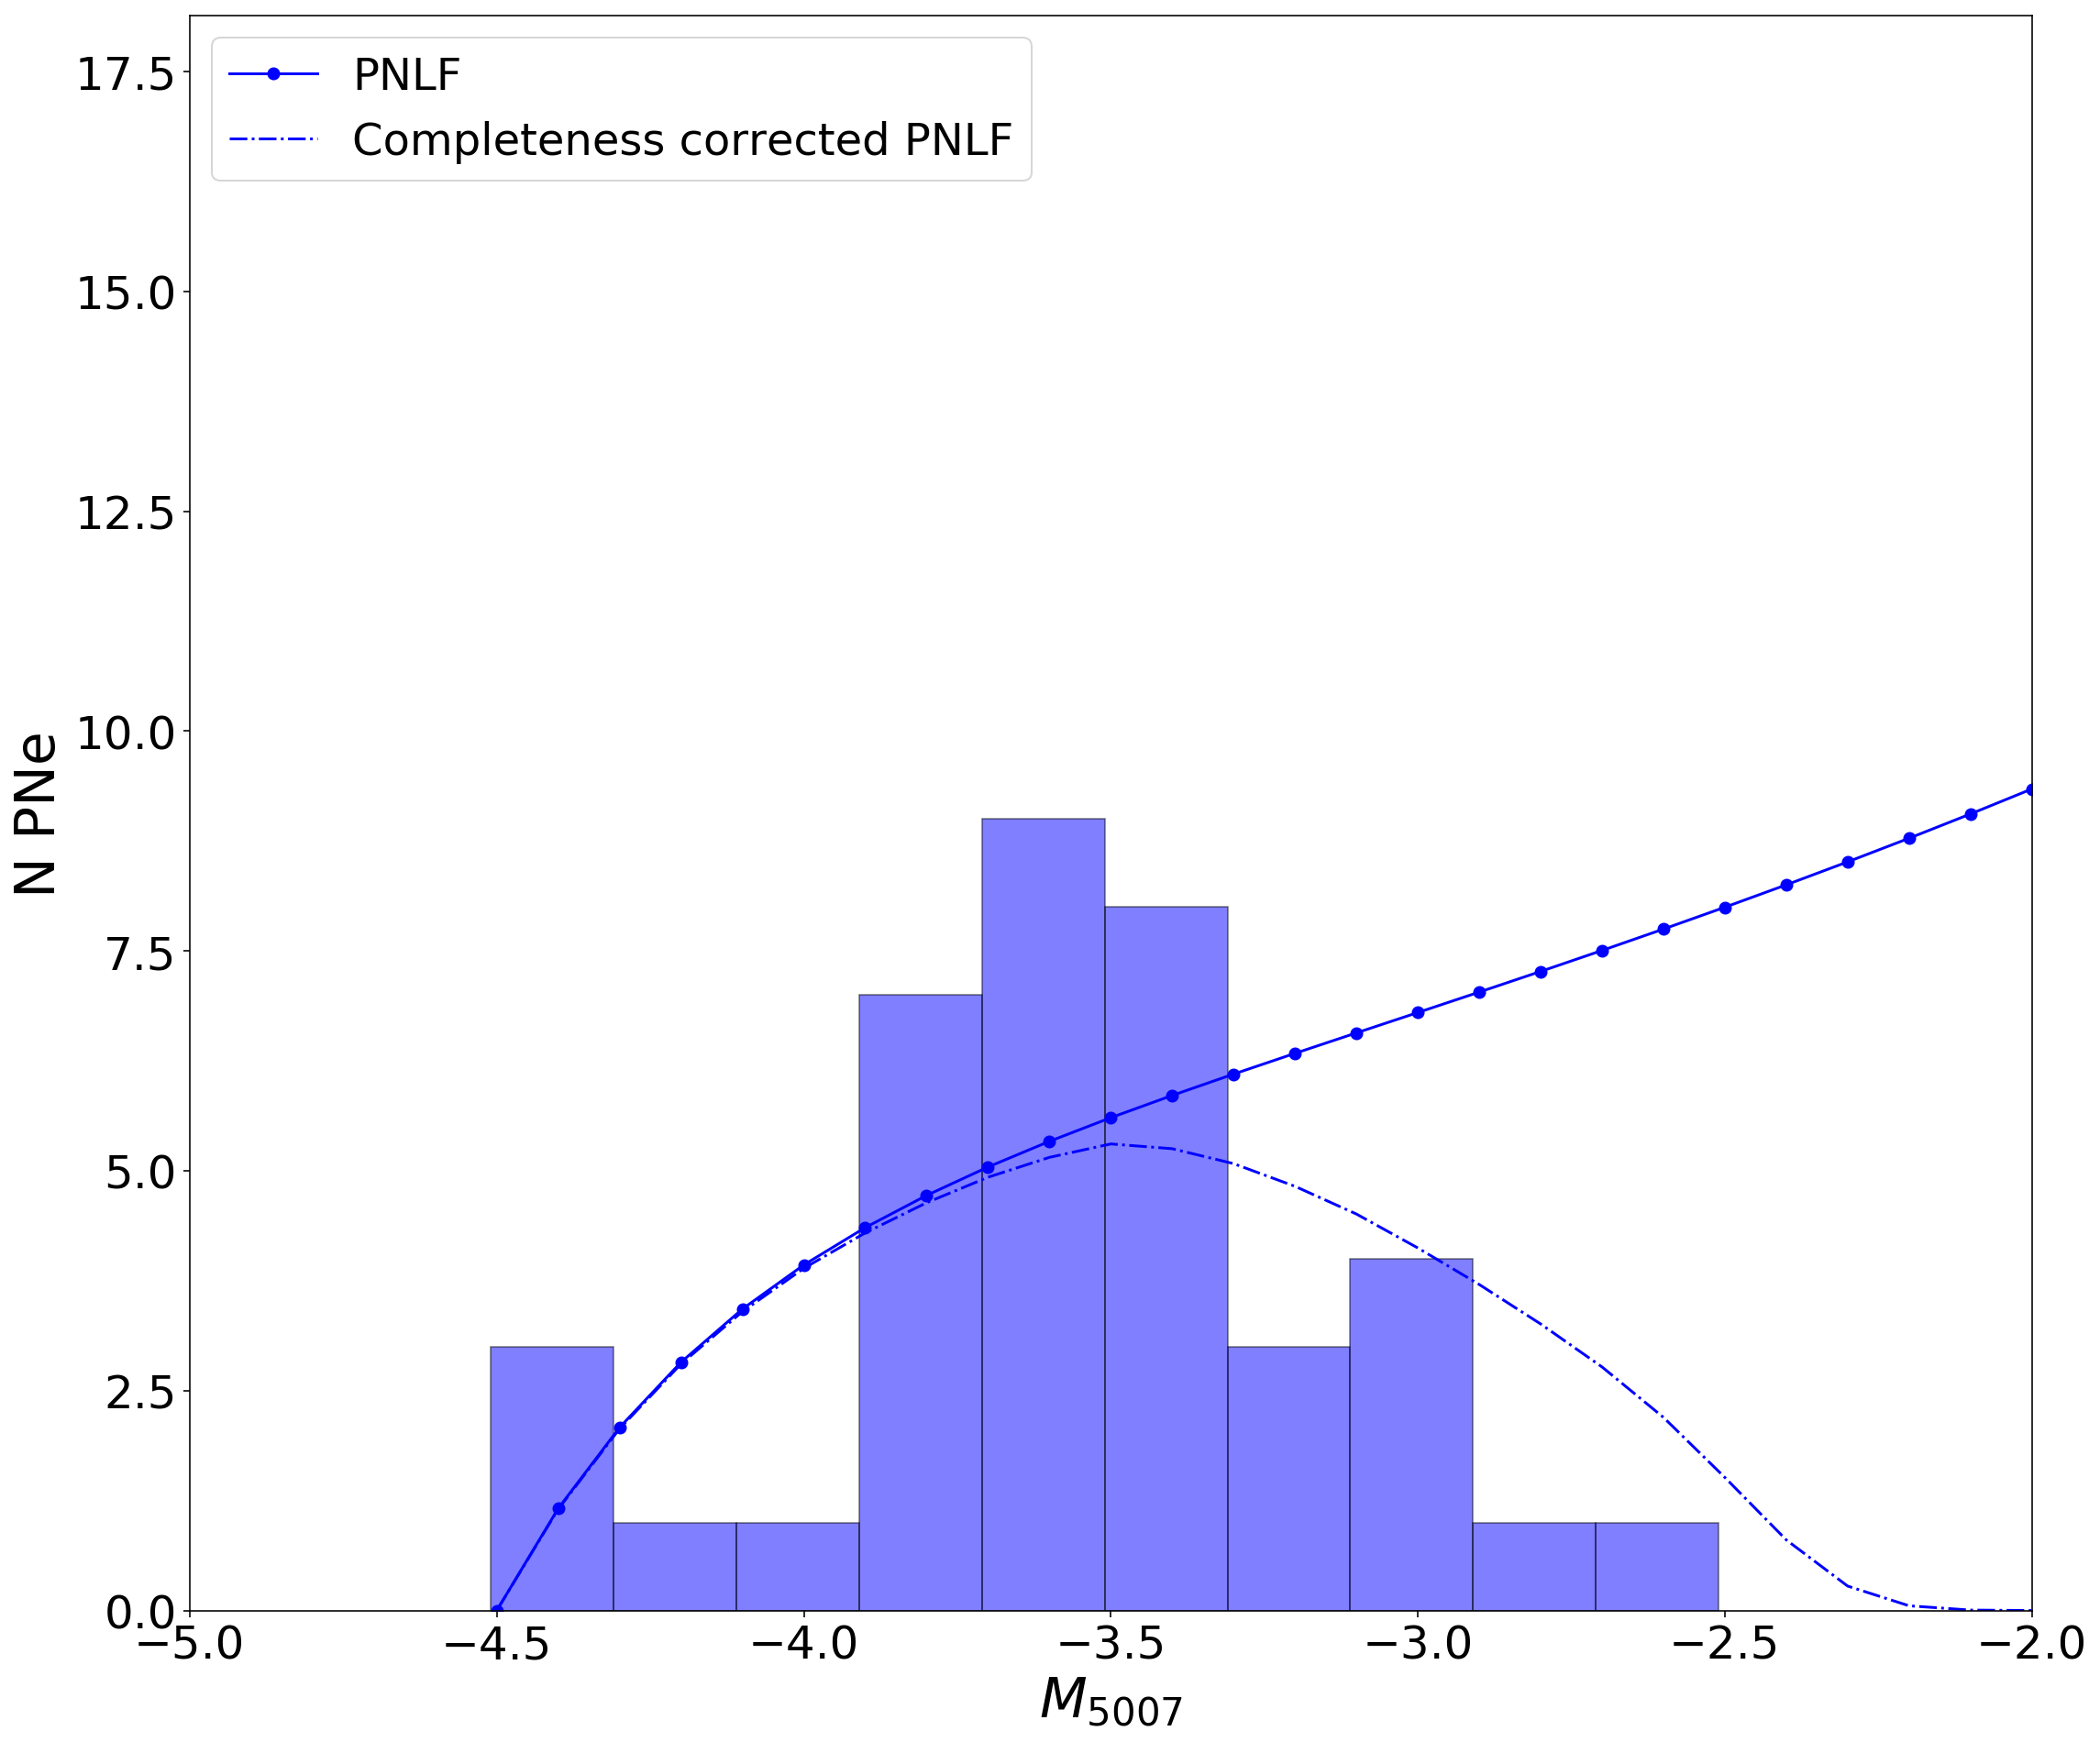

In [13]:
x_data_cen, y_data_cen, map_cen, aux = open_data(gal_name)

image, wave = reconstructed_image(gal_name)
image = image.reshape([y_data_cen,x_data_cen])

mag = PNe_df["M 5007"].loc[PNe_df["Filter"]=="Y"].values

# Total PNLF
PNLF, PNLF_corr, Abs_M = completeness(gal_name, mag, PNe_multi_params, Dist_est, image, peak=3., gal_mask_params=gal_mask, star_mask_params=star_mask, mask=True, c1=0.307 ) # Estimating the completeness for the central pointing
#PNLF_plus, PNLF_corr_plus, Abs_M_plus = completeness(gal_name, mag, PNe_multi_params, D_est_plus, image, 2.75, mask=True ) # Estimating the completeness for the central pointing
#PNLF_min, PNLF_corr_min, Abs_M_min = completeness(gal_name, mag, PNe_multi_params, D_est_plus, image, 2.75, mask=True ) # Estimating the completeness for the central pointing

# Getting the normalisation
total_norm = np.sum(np.abs(PNLF_corr))*abs(Abs_M[1]-Abs_M[0])
#total_norm_plus = np.sum(PNLF_corr_plus)*abs(Abs_M_plus[1]-Abs_M_plus[0])
#total_norm_min = np.sum(PNLF_corr_min)*abs(Abs_M_min[1]-Abs_M_min[0])

# Scaling factor
scal = len(mag)/total_norm
#scal_plus = len(mag)/total_norm_plus
#scal_min = len(mag)/total_norm_min

# Constraining to -2.0 in magnitude
idx = np.where(Abs_M <= -2.0)
# Total number of PNe
tot_N_PNe = np.sum(PNLF_corr[idx]*scal)*abs(Abs_M[1]-Abs_M[0])
#tot_N_PNe_plus = np.sum(PNLF_corr_plus[idx]*scal_plus)*abs(Abs_M_plus[1]-Abs_M_plus[0])
#tot_N_PNe_min = np.sum(PNLF_corr_min[idx]*scal_min)*abs(Abs_M_min[1]-Abs_M_min[0])

plt.figure(figsize=(18,16))

binwidth = 0.2
hist = plt.hist(mag, bins=np.arange(min(mag), max(mag) + binwidth, binwidth), edgecolor="black", linewidth=0.8, alpha=0.5, color='blue')

ymax = max(hist[0])

plt.plot(Abs_M, PNLF*scal*binwidth, '-', color='blue', marker="o", label="PNLF")
plt.plot(Abs_M, PNLF_corr*scal*binwidth,'-.', color='blue', label="Completeness corrected PNLF")

plt.xlabel('$M_{5007}$', fontsize=30)
plt.ylabel('N PNe', fontsize=30)
#plt.yticks(np.arange(0,ymax+4, 5))

plt.xlim(-5.0,-2.0);# plt.ylim(,45);
plt.tick_params(labelsize = 25)

#plt.axvline(PNe_df["m 5007"].loc[PNe_df["Filter"]=="Y"].values.min() - 31.63)
plt.legend(loc=2, fontsize=24)
#plt.savefig("Plots/"+gal_name+"/"+gal_name+"_PNLF.pdf", bbox_inches='tight')

In [14]:
step = Abs_M[1]-Abs_M[0]
N_PNe = np.sum(PNLF[:25]*scal)*step
print("Number of PNe from PNLF: ", N_PNe, "+/-", np.sqrt(N_PNe))

Number of PNe from PNLF:  71.1455892396927 +/- 8.43478448092734


In [ ]:
FCC167 - Number of PNe from PNLF:  342.8 +/- 18.5
FCC219 - Number of PNe from PNLF:  168.1 +/- 12.9
FCC193 - Number of PNe from PNLF:  249.8 +/- 15.8
FCC161 - Number of PNe from PNLF:  211.8 +/- 14.5
FCC147 - Number of PNe from PNLF:  112.5 +/- 10.6
FCC083 - Number of PNe from PNLF:  139.8 +/- 11.8
FCC255 - Number of PNe from PNLF:  71.10 +/- 8.40



## Alpha

In [ ]:

file_name = gal_name+"_data/"+gal_name+"center.fits"

lum_g_bol = ppxf_L_tot(file=file_name, gal_mask_params=gal_mask, star_mask_params=star_mask, mask=False, 
                       redshift=z, vel=gal_vel, dist_mod=dM)



In [ ]:

file_name = gal_name+"_data/"+gal_name+"center.fits"

lum_g_bol = ppxf_L_tot(file=file_name, gal_mask_params=gal_mask, star_mask_params=star_mask, mask=False, 
                       redshift=0.004306, vel=1288, dist_mod=31.67841158479284)



/auto/data/tspriggs/Github/MUSE_PNe_fitting/ppxf_gal_L.py:229: RuntimeWarning: invalid value encountered in log10
  mags = -2.5 * np.log10(fluxes) - f.Vega_zero_mag
/auto/data/tspriggs/Github/MUSE_PNe_fitting/ppxf_gal_L.py:131: RuntimeWarning: divide by zero encountered in true_divide
  templates[:, j] = sspNew/np.median(sspNew)  # Normalizes templates
/auto/data/tspriggs/Github/MUSE_PNe_fitting/ppxf_gal_L.py:131: RuntimeWarning: invalid value encountered in true_divide
  templates[:, j] = sspNew/np.median(sspNew)  # Normalizes templates


In [7]:
lum_g_bol

nan

#### FCC167 - 23740270563.169445
#### FCC219 - 11678451763.86619
#### FCC161 - 8973042025.01011
#### FCC147 - 5600381182.962889
#### FCC193 - 4251389233.8368816
#### FCC083 - 4588451801.077266

In [74]:
N_PNe/lum_g_bol

3.047551952439538e-08

#### FCC167 - 14.44e-9
#### FCC219 - 14.40e-9
#### FCC161 - 2.360e-8
#### FCC147 - 2.006e-8
#### FCC193 - 5.876e-8
#### FCC083 - 3.047e-8



In [16]:
np.log10(5.876e-8)

-7.2309182128817815

In [73]:
14.4e-9

1.44e-08

In [75]:
a_2_5_log = np.log10([14.44e-9, 14.40e-9, 2.36e-8, 2.006e-8, 5.876e-8, 3.047e-8])
NUV_m = np.array([15.29, 12.25, 16.27, 16.13, 16.75, 16.85])
NUV_L = np.array([3.91e8, 1.67e9, 1.53e8, 2.1e8, 1.06e8, 1.13e8])

Text(0.5, 0, 'UV L')

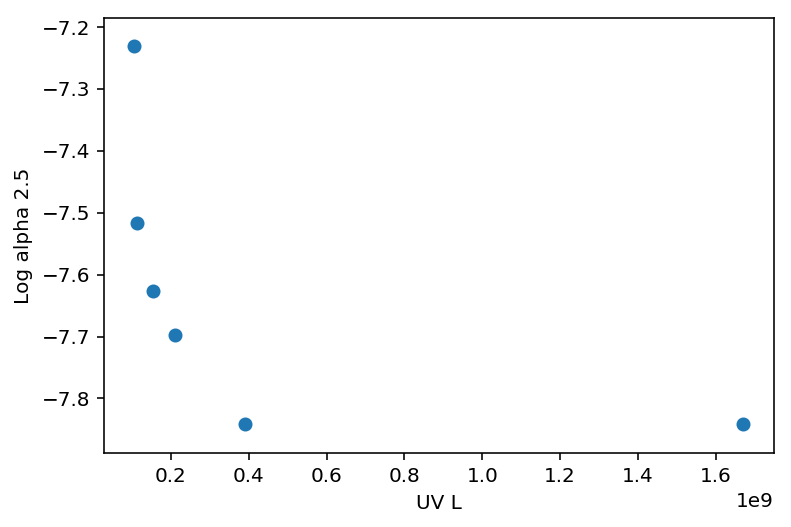

In [82]:
plt.figure()
plt.scatter(UV_m, a_2_5_log)
plt.ylabel("Log alpha 2.5")
plt.xlabel("UV mag")

plt.figure()
plt.scatter(UV_L, a_2_5_log)
plt.ylabel("Log alpha 2.5")
plt.xlabel("UV L")

In [ ]:
FCC167 - Number of PNe from PNLF:  342.8 +/- 18.5
FCC219 - Number of PNe from PNLF:  168.1 +/- 12.9
FCC161 - Number of PNe from PNLF:  211.8 +/- 14.5
FCC147 - Number of PNe from PNLF:  112.5 +/- 10.6
FCC193 - Number of PNe from PNLF:  249.8 +/- 15.8
FCC083 - Number of PNe from PNLF:  139.8 +/- 11.8

In [ ]:
#### FCC167 - 23740270563.169445
#### FCC219 - 11678451763.86619
#### FCC161 - 8973042025.01011
#### FCC147 - 5600381182.962889
#### FCC193 - 4251389233.8368816
#### FCC083 - 4588451801.077266

In [127]:
N_PNe = np.array([342.8, 168.1, 211.8, 112.5, 249.8, 139.8])
N_PNe_pm = np.array([18.5, 12.9, 14.5, 10.6, 15.8, 11.8])
L_bol = np.array([23740270563.169445, 11678451763.86619, 8973042025.01011, 5600381182.962889, 4251389233.8368816, 4588451801.077266])

a_2_5_list = np.log10(N_PNe / L_bol)
a_2_5_upper = np.log10((N_PNe+N_PNe_pm) / L_bol)
a_delta_upper = a_2_5_upper - a_2_5_list
a_2_5_lower = np.log10((N_PNe-N_PNe_pm) / L_bol)
a_delta_lower = a_2_5_list - a_2_5_lower


In [136]:
gal_names = ["FCC167", "FCC219", "FCC161", "FCC147", "FCC193", "FCC083"]
a_2_5_log = np.log10([14.44e-9, 14.40e-9, 2.36e-8, 2.006e-8, 5.876e-8, 3.047e-8])
FUV_m = np.array([16.78, 16.41, 17.98, 17.65, 19.00, 18.36])

plt.figure(figsize=(14,10))
plt.scatter(FUV_m, a_2_5_log)
plt.ylabel("Log alpha 2.5", fontsize=25)
plt.xlabel("FUV mag", fontsize=25)
plt.errorbar(FUV_m, a_2_5_log, xerr=0.02, yerr= np.median((a_delta_upper, a_delta_lower), 0), ls="None")
plt.tick_params(labelsize=15)
plt.ylim(-8,-6)
ax = plt.gca()
for i, name in enumerate(gal_names):
    ax.annotate(name, (FUV_m[i]-0.08, a_2_5_log[i]+0.05), color="black", size=12)

#plt.savefig("Plots/Doing_science.pdf", bbox_inches='tight')


In [48]:
for_ralf = Table([Buzzoni_log_a, Buzzoni_UV_m_V, Buzzoni_FUV, Buzzoni_V,Buzzoni_FUV_m_V], names=("paper_log_a", "paper_UV_minus_V", "NED_FUV", "NED_V", "NED_FUV_minus_V"))
ascii.write(for_ralf, "exported_data/for_ralf.dat")

In [51]:
gal_names = ["FCC167", "FCC219", "FCC161", "FCC147", "FCC193", "FCC083"]

V_mag = np.array([10.84, 10.62, 11.75, 11.77, 12.02, 12.39])
a_2_5_log = np.log10([14.44e-9, 14.40e-9, 2.36e-8, 2.006e-8, 5.876e-8, 3.047e-8])
FUV_m = np.array([16.78, 16.41, 17.98, 17.65, 19.00, 18.36])

FUV_minus_V = FUV_m - V_mag

Buzzoni_UV_m_V = np.array([1.19, 4.50, 3.51, 5.0, 1, 2.05, 1,  3.43,1, 3.86, 3.9, 3.55, 4.22, 3.72, 3.42, 2.04,1, 2.24, 3.41, 1])
Buzzoni_log_a  = np.array([-6.88, -6.77, -6.94, -7.5, -6.75, -7.30, -6.8, -6.59, -6.43, -6.77, -6.42, -6.77, -6.7, -6.89, -7.16, -7.10, -6.66, -7.22, -6.82, -6.3])
Buzzoni_table = ascii.read("exported_data/FUV_minus_V_table.dat")
Buzzoni_FUV_m_V = Buzzoni_table["FUV - V"]
Buzzoni_FUV = Buzzoni_table["FUV"]
Buzzoni_V = Buzzoni_table["V"]

plt.figure(figsize=(14,10))
#plt.scatter(FUV_minus_V, a_2_5_log, c="b", label="F3D")
#plt.scatter(np.array(Buzzoni_FUV_m_V), Buzzoni_log_a-1, c="r", label="Buzzoni, 2006")
plt.scatter(FUV_minus_V, a_2_5_log, c="b", label="F3D")
plt.scatter(Buzzoni_FUV_m_V, Buzzoni_log_a-1, c="r", label="Buzzoni, 2006")
plt.ylabel(r"Log $ \alpha_{2.5}$", fontsize=25)
plt.xlabel("FUV - V mag", fontsize=25)
#plt.errorbar(FUV_minus_V, a_2_5_log, xerr=0.02, yerr=np.median((a_delta_upper, a_delta_lower), 0), ls="None")
plt.tick_params(labelsize=15)
#plt.ylim(-8,-6)
#plt.xlim(10,)
plt.legend()
ax = plt.gca()
#for i, name in enumerate(gal_names):
#    ax.annotate(name, (FUV_minus_V[i]-0.08, a_2_5_log[i]+0.05), color="black", size=12)

#ax.annotate("FCC021", (Buzzoni_UV_m_V[3]-0.08, Buzzoni_log_a[3]+0.05), color="black", size=12)
#plt.savefig("Plots/Buzzoni_FUV_minus_V.pdf", bbox_inches='tight')


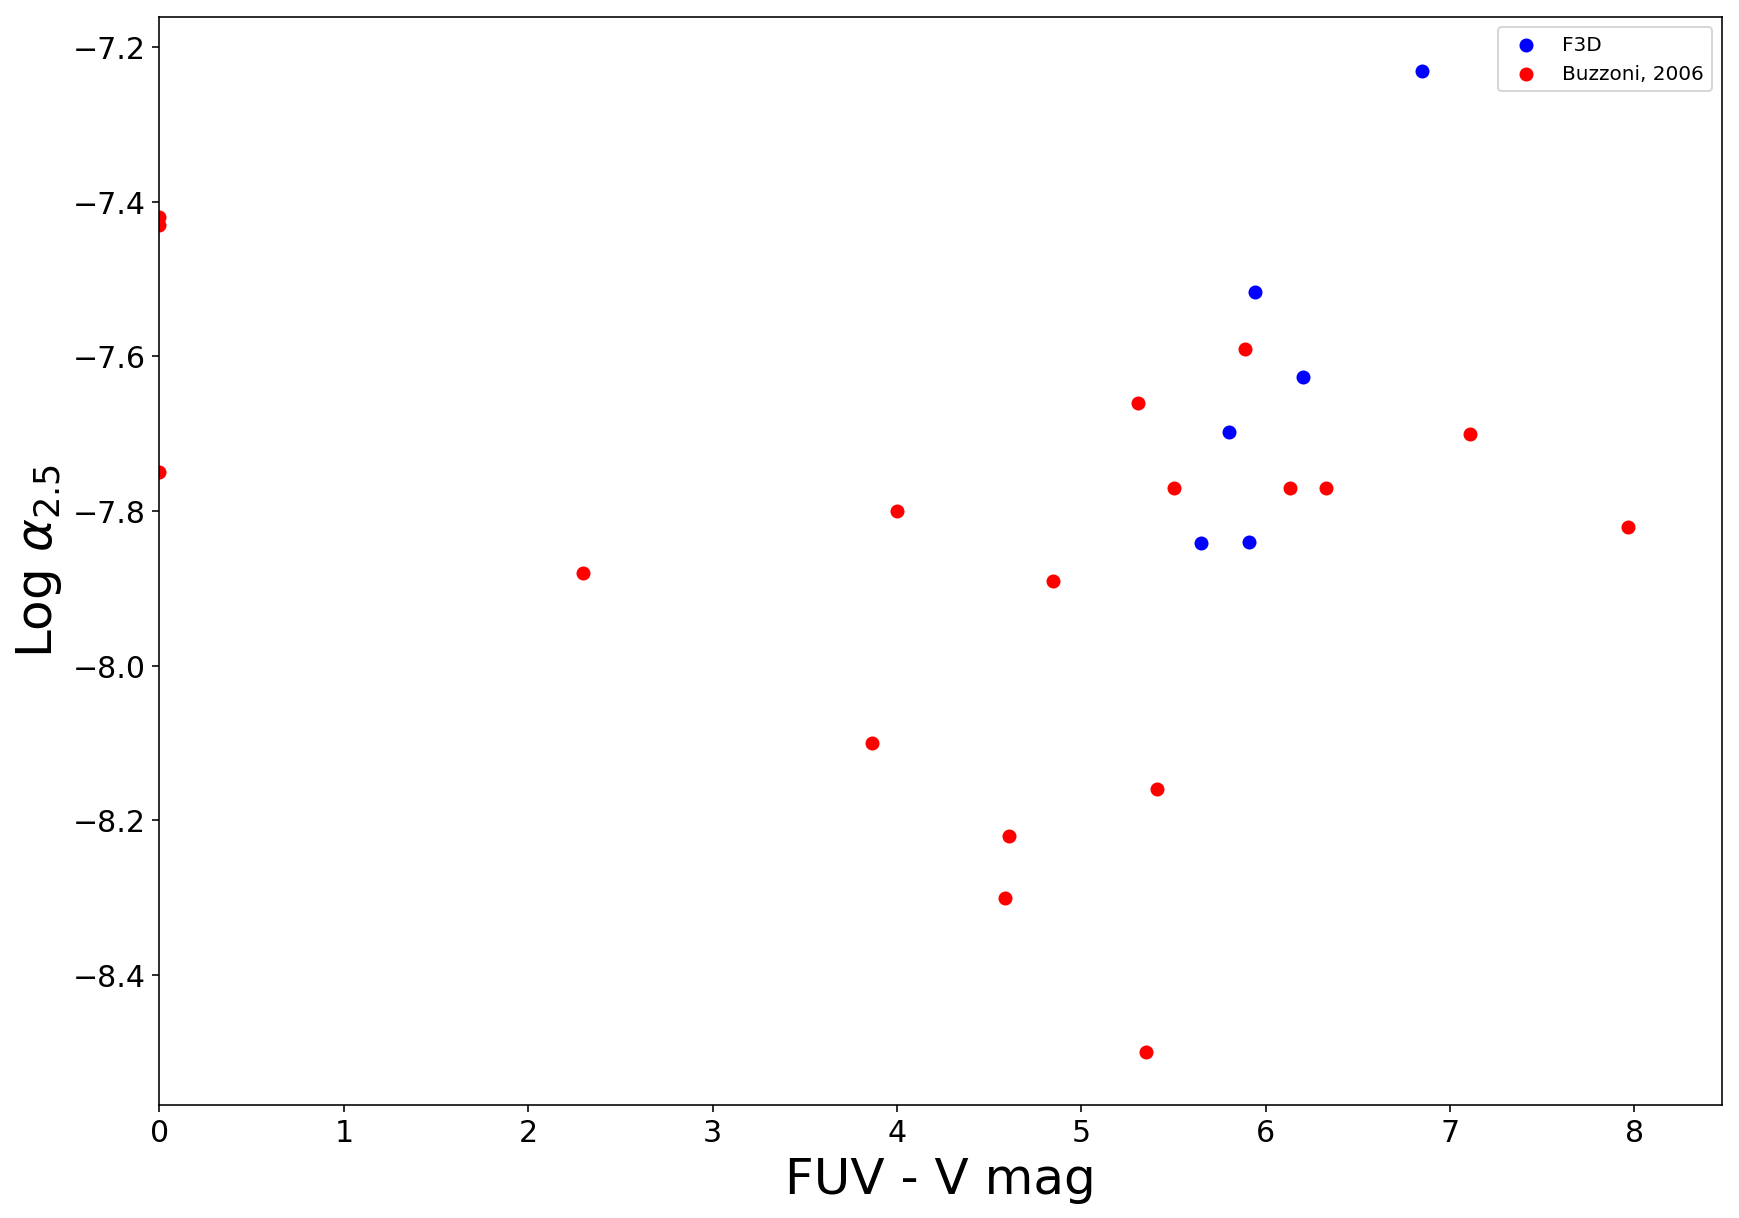

In [118]:
gal_names = ["FCC167", "FCC219", "FCC161", "FCC147", "FCC193", "FCC083"]

V_mag = np.array([10.87, 10.76, 11.78, 11.85, 12.15, 12.42])
a_2_5_log = np.log10([14.44e-9, 14.40e-9, 2.36e-8, 2.006e-8, 5.876e-8, 3.047e-8])
FUV_m = np.array([16.78, 16.41, 17.98, 17.65, 19.00, 18.36])

FUV_minus_V = FUV_m - V_mag

Buzzoni_UV_m_V = np.array([1.19, 4.50, 3.51, 5.0, 1, 2.05, 1,  3.43,1, 3.86, 3.9, 3.55, 4.22, 3.72, 3.42, 2.04,1, 2.24, 3.41, 1])
Buzzoni_log_a  = np.array([-6.88, -6.77, -6.94, -7.5, -6.75, -7.30, -6.8, -6.59, -6.43, -6.77, -6.42, -6.77, -6.7, -6.89, -7.16, -7.10, -6.66, -7.22, -6.82, -6.3])
Buzzoni_table = ascii.read("exported_data/FUV_minus_V_table.dat")
Buzzoni_FUV_m_V = Buzzoni_table["FUV - V"]
Buzzoni_FUV = Buzzoni_table["FUV"]

plt.figure(figsize=(14,10))
plt.scatter(FUV_minus_V, a_2_5_log, c="b", label="F3D")
plt.scatter(np.array(Buzzoni_FUV_m_V), Buzzoni_log_a-1, c="r", label="Buzzoni, 2006")
#plt.scatter(FUV_minus_V, a_2_5_log, c="b", label="F3D")
#plt.scatter(Buzzoni_UV_m_V, Buzzoni_log_a, c="r", label="Buzzoni, 2006")
plt.ylabel(r"Log $ \alpha_{2.5}$", fontsize=25)
plt.xlabel("FUV - V mag", fontsize=25)
#plt.errorbar(FUV_minus_V, a_2_5_log, xerr=0.02, yerr=np.median((a_delta_upper, a_delta_lower), 0), ls="None")
plt.tick_params(labelsize=15)
#plt.ylim(-8,-6)
plt.xlim(0,)
plt.legend()
ax = plt.gca()
#for i, name in enumerate(gal_names):
#    ax.annotate(name, (FUV_minus_V[i]-0.08, a_2_5_log[i]+0.05), color="black", size=12)

#ax.annotate("FCC021", (Buzzoni_UV_m_V[3]-0.08, Buzzoni_log_a[3]+0.05), color="black", size=12)
plt.savefig("Plots/Buzzoni_FUV_minus_V.pdf", bbox_inches='tight')


In [ ]:
Buzzoni_UV_m_V = [1.19,4.50, 3.51, 5.0, 2.05, 3.43, 3.86, 3.9, 3.55, 4.22, 3.72, 3.42, 2.04, 2.24. 3.41]
Buzzoni_log_a  = [-6.88, -6.77, -6.94, -7.5, 7.30, 6.59, 6.43, 6.77, 6.42, -6.77, -6.7, 6.89, -7.16, -7.10, -7.22, -6.82 ]

In [ ]:
v_B_07 = Vizier(columns=["asyFUV", "Vmag"], catalog="J/ApJS/173/185/galex")
v_B_15 = Vizier(columns=["FUV (mag)", "r.fov (deg)", "e_FUV (mag)"], catalog="II/312/ais")

list_of_B_g = ["205", "221", "224", "1316", "1344", "1399", "3031", "3115",
                 "3377", "3379", "3384", "4374", "4382", "4406", "4477", "4486",
                 "4594", "4649", "4697", "5128"]

Buzz_df = pd.DataFrame(columns=("N", "FUV_07", "FUV_15", "r.fov", "Vmag", "e_FUV_15"))
Buzz_df["N"] = range(len(list_of_B_g))



for i, g in enumerate(list_of_B_g):
    q_result_07 = v_B_07.query_object("NGC"+g, catalog="J/ApJS/173/185/galex")
    q_result_15 = v_B_15.query_object("NGC"+g, catalog="II/312/ais")
    print(i)
    if len(q_result_07) == 0: #check if Table has no entries for galaxy g
        continue
    else:
        Buzz_df.loc[i, "FUV_07"] = np.copy(q_result_07[0][0]["asyFUV"])
        Buzz_df.loc[i, "Vmag"] = np.copy(q_result_07[0][0]["Vmag"])
    
    if len(np.array(q_result_15)) == 0: # check if Table has no entries for galaxy g
        continue
    elif len(np.array(q_result_15[0])) == 1: # check if only one entry for galaxy g
        if np.array(q_result_15[0])["FUV"] == np.nan: # If only one entry, and is a nan, return "no data"
            continue
        else: # if only one entry, but has values, then store values
            non_nan_results = np.array(q_result_15[0])
            Buzz_df.loc[i, "FUV_15"]   = non_nan_results["FUV"][0]
            Buzz_df.loc[i, "r.fov"]    = non_nan_results["r.fov"][0]
            Buzz_df.loc[i, "e_FUV_15"] = non_nan_results["e_FUV"][0]
    else: # If more than one entry....
        non_nan_results = np.array((q_result_15[0]))[np.array(q_result_15[0]["FUV"])>0]
        if len(non_nan_results)==0: # check that entry, after masking for nans, is empty or not
            continue
        else: # if masked table (for nans) is not empty, store FUV, eFUV and r.fov values associated with max r.fov
            max_rfov_idx = np.argmax(non_nan_results["r.fov"])        
            max_rfov_idx = np.argmax(non_nan_results["r.fov"])
            Buzz_df.loc[i, "FUV_15"]   = non_nan_results["FUV"][max_rfov_idx]
            Buzz_df.loc[i, "r.fov"]    = np.max(non_nan_results["r.fov"])
            Buzz_df.loc[i, "e_FUV_15"]= non_nan_results["e_FUV"][max_rfov_idx]


Buzz_df["alpha"] = np.array([-6.88, -6.77, -6.94, -7.5, -6.75, -7.30, -6.8, -6.59, -6.43, -6.77, -6.42, -6.77, -6.7, -6.89, -7.16, -7.10, -6.66, -7.22, -6.82, -6.3])

In [586]:
N_PNe = np.array([342.8, 168.1, 211.8, 112.5, 249.8, 139.8])
N_PNe_pm = np.array([18.5, 12.9, 14.5, 10.6, 15.8, 11.8])
L_bol = np.array([23740270563.169445, 11678451763.86619, 8973042025.01011, 5600381182.962889, 4251389233.8368816, 4588451801.077266])

a_2_5_list = np.log10(N_PNe / L_bol)
a_2_5_upper = np.log10((N_PNe+N_PNe_pm) / L_bol)
a_delta_upper = a_2_5_upper - a_2_5_list
a_2_5_lower = np.log10((N_PNe-N_PNe_pm) / L_bol)
a_delta_lower = a_2_5_list - a_2_5_lower



F3D_galaxies = ["FCC167", "FCC219", "FCC161", "FCC147", "FCC193", "FCC083"]
a_2_5_log = np.log10([14.44e-9, 14.40e-9, 2.36e-8, 2.006e-8, 5.876e-8, 3.047e-8])

v_B_15 = Vizier(columns=["AsyFUV", "e_AsyFUV", "Bmag", "e_Bmag", "B-V"])

F3D_tables = []
for f in F3D_galaxies:
    F3D_tables.append(v_B_15.query_object(f, catalog="J/ApJS/220/6/uvgal"))

F3D_FUV = np.ones(len(F3D_tables))
F3D_FUV_err = np.ones_like(F3D_FUV)
F3D_Bmag = np.ones_like(F3D_FUV)
F3D_Bmag_err = np.ones_like(F3D_FUV)
F3D_B_m_V = np.ones_like(F3D_FUV)

for i, t in enumerate(F3D_tables):
    if len(t) == 0:
        continue
    else:
        F3D_FUV[i] = t[0][0]["AsyFUV"]
        F3D_FUV_err[i] = t[0][0]["e_AsyFUV"]
        F3D_Bmag[i]   = t[0][0]["Bmag"]
        F3D_Bmag_err[i] = t[0][0]["e_Bmag"]
        F3D_B_m_V[i]  = t[0][0]["B-V"]
        
F3D_Vmag = F3D_Bmag - F3D_B_m_V
F3D_FUV_m_V = F3D_FUV - F3D_Vmag

##### Buzzoni data
list_of_B_g = ["205", "221", "224", "1316", "1344", "1399", "3031", "3115",
                 "3377", "3379", "3384", "4374", "4382", "4406", "4477", "4486",
                 "4594", "4649", "4697", "5128"]

Buzzoni_log_a  = np.array([-6.88, -6.77, -6.94, -7.5, -6.75, -7.30, -6.8, -6.59, -6.43, -6.77, -6.42, -6.77, -6.7, -6.89, -7.16, -7.10, -6.66, -7.22, -6.82, -6.3])

Buzzoni_tables = []
for g in list_of_B_g:
    Buzzoni_tables.append(v_B_15.query_object("NGC"+g, catalog="J/ApJS/220/6/uvgal"))

B_FUV = np.ones(len(Buzzoni_tables))
B_FUV_err = np.ones_like(B_FUV)
B_Bmag = np.ones_like(B_FUV)
B_Bmag_err = np.ones_like(B_FUV)
B_B_m_V = np.ones_like(B_FUV)

for i, t in enumerate(Buzzoni_tables):
    if len(t) == 0:
        continue
    else:
        B_FUV[i]      = t[0][0]["AsyFUV"]
        B_FUV_err[i]  = t[0][0]["e_AsyFUV"]
        B_Bmag[i]     = t[0][0]["Bmag"]
        B_Bmag_err[i] = t[0][0]["e_Bmag"]
        B_B_m_V[i]    = t[0][0]["B-V"]
        
B_Vmag = B_Bmag - B_B_m_V
B_FUV_m_V = B_FUV - B_Vmag

/local/tspriggs/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: UserWarning: Warning: converting a masked element to nan.
/local/tspriggs/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: UserWarning: Warning: converting a masked element to nan.
/local/tspriggs/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:62: UserWarning: Warning: converting a masked element to nan.
/local/tspriggs/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:63: UserWarning: Warning: converting a masked element to nan.


In [615]:
Vmag[19]

6.430000185966492

In [579]:
F3D_Vmag

array([ 9.90999991,  9.88000017, 10.90999997, 11.02999955, 11.47000009,
       11.51000011])

In [609]:
plt.figure(figsize=(14,10))
plt.scatter(B_FUV_m_V, Buzz_df["alpha"]-1, c="r", label=r"Buzzoni 2006 $\alpha$")
plt.scatter(F3D_FUV_m_V, a_2_5_log, c="b", label="F3D")
plt.errorbar(F3D_FUV_m_V, a_2_5_log, xerr=F3D_Bmag_err+F3D_FUV_err, yerr= np.median((a_delta_upper, a_delta_lower), 0), c="b", ls="None")
plt.errorbar(B_FUV_m_V, Buzz_df["alpha"]-1, xerr=B_Bmag_err+B_FUV_err, yerr=0.08, c="r", ls="None", label=None)

plt.xlim(4,)
plt.xlabel("FUV - V (mag)", fontsize=20)
plt.ylabel(r"$Log_{10}(\alpha_{2.5})$", fontsize=20)
plt.legend(fontsize=20)
plt.savefig("Plots/Updated Buzzoni vs F3D.png")

In [612]:
np.argmin(Buzz_df["alpha"]-1)

/local/tspriggs/miniconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return getattr(obj, method)(*args, **kwds)


3

In [611]:
Buzz_df

N FUV_07  FUV_15     r.fov   Vmag e_FUV_15  alpha
0    0  14.54     NaN  0.333394   8.07      NaN  -6.88
1    1  15.84     NaN       NaN   8.08      NaN  -6.77
2    2   8.83     NaN       NaN   3.44      NaN  -6.94
3    3  15.33  17.156  0.206068   8.53    0.057  -7.50
4    4    NaN     NaN       NaN    NaN      NaN  -6.75
5    5  15.11  20.323  0.264926   9.59    0.261  -7.30
6    6   11.4     NaN       NaN   6.94      NaN  -6.80
7    7    NaN     NaN       NaN    NaN      NaN  -6.59
8    8    0.0  20.499  0.245664  10.38    0.215  -6.43
9    9    NaN     NaN       NaN    NaN      NaN  -6.77
10  10    NaN     NaN       NaN    NaN      NaN  -6.42
11  11  15.92  19.548  0.445657   9.11    0.139  -6.77
12  12    NaN     NaN       NaN    NaN      NaN  -6.70
13  13  15.62  17.341  0.377534    8.9    0.062  -6.89
14  14  17.22  21.172  0.431543  10.42    0.395  -7.16
15  15  14.57  16.218   0.45684   8.63    0.032  -7.10
16  16  14.94     NaN       NaN    8.0      NaN  -6.66
17  17    NaN     NaN       NaN    NaN      NaN  -7.22
18  18    NaN     NaN       NaN    NaN      NaN  -6.82
19  19  12.58  14.765  0.110751   6.84    0.015  -6.30